In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy
from datetime import datetime
import statsmodels.formula.api as smf

from matplotlib import style
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.font_manager import FontProperties
from pylab import mpl
import platform

# 根据操作系统设置中文字体
system = platform.system()
if system == 'Windows':
    plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows使用黑体
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
elif system == 'Darwin':  # macOS
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # macOS使用Arial Unicode MS
    plt.rcParams['axes.unicode_minus'] = False
else:  # Linux
    plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']  # Linux使用文泉驿微米黑
    plt.rcParams['axes.unicode_minus'] = False

# 输出矢量图
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# 设置pandas显示选项
pd.set_option('display.max_columns', None)

print(f"当前操作系统: {system}")
print(f"字体设置: {plt.rcParams['font.sans-serif']}")

当前操作系统: Windows
字体设置: ['SimHei']


In [2]:
cross = pd.read_csv('TRD_Mnth202509.csv')
from pandas.tseries.offsets import MonthEnd
# 处理月份格式
cross['month'] = pd.to_datetime(cross['Trdmnt'], format='%Y-%m') + MonthEnd(1)
# 补齐股票代码 如果不满6位 在前面补上0
cross['Stkcd'] = cross['Stkcd'].apply(lambda x: '{:0>6}'.format(x)) # 6位股票代码
# 重命名列以匹配后续代码
cross.rename(columns={'Mretwd': 'Return', 'Msmvosd': 'floatingvalue', 'Msmvttl': 'totalvalue'}, inplace=True)

# 导入无风险利率数据
rf_data = pd.read_csv('Marketret_mon_stock2024.csv')
# 处理月份格式
rf_data['month'] = pd.to_datetime(rf_data['month'], format='%b %Y') + MonthEnd(1)
# 只保留需要的列
rf_data = rf_data[['month', 'rfmonth']]

# 合并无风险利率到cross
cross = pd.merge(cross, rf_data, on='month', how='left')

# 添加一个序列 用来统计公司上市的第几个月
cross = cross.sort_values(by=['Stkcd', 'month'])
cross['list_month'] = cross.groupby('Stkcd').cumcount() + 1

# 计算超额收益率
cross['ret'] = cross['Return'] - cross['rfmonth']
cross['floatingvalue'] = cross['floatingvalue'] * 1000
cross['totalvalue'] = cross['totalvalue'] * 1000

cross#导出数据

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret
0,000001,1991-04,3,49.00,30,43.68,13400,6.150000e+05,1.157520e+09,2.118487e+09,20,NaN,NaN,4,1991-04-03,NaN,NaN,1991-04-30,0.006651,1,NaN
1,000001,1991-05,2,43.46,31,38.34,187800,7.675000e+06,1.016010e+09,1.859497e+09,24,-0.122253,0.235714,4,1991-04-03,NaN,NaN,1991-05-31,0.006092,2,-0.128345
2,000001,1991-06,1,38.53,28,33.99,30600,1.094000e+06,9.007350e+08,1.648521e+09,23,-0.113459,-0.113459,4,1991-04-03,NaN,NaN,1991-06-30,0.006092,3,-0.119551
3,000001,1991-07,1,33.65,31,29.54,6100,1.940430e+05,7.828100e+08,1.432695e+09,16,-0.130921,-0.130921,4,1991-04-03,NaN,NaN,1991-07-31,0.006092,4,-0.137013
4,000001,1991-08,1,29.39,31,15.00,3243100,4.957624e+07,6.748338e+08,1.346275e+09,15,-0.411588,-0.411587,4,1991-08-01,NaN,NaN,1991-08-31,0.006092,5,-0.417680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886908,920992,2025-05,6,20.00,30,20.46,92609592,1.922463e+09,5.707967e+08,1.979115e+09,19,0.051312,0.051715,64,2023-04-25,0.0,0.0,2025-05-31,NaN,32,NaN
886909,920992,2025-06,3,20.40,30,21.26,73152031,1.580767e+09,5.931152e+08,2.056500e+09,20,0.039101,0.039101,64,2023-04-25,0.0,0.0,2025-06-30,NaN,33,NaN
886910,920992,2025-07,1,21.13,31,22.44,96064221,2.126994e+09,6.260351e+08,2.170642e+09,23,0.055503,0.055503,64,2023-04-25,0.0,0.0,2025-07-31,NaN,34,NaN
886911,920992,2025-08,1,22.12,29,21.65,63953451,1.432608e+09,6.039955e+08,2.094225e+09,21,-0.035205,-0.035205,64,2023-04-25,0.0,0.0,2025-08-31,NaN,35,NaN


In [3]:
# 生成下一个月的收益率

# 方法1：补全所有个股的日期序列，再使用shift
# 创建所有日期和股票代码的完整组合
all_months = pd.DataFrame(cross['month'].unique(), columns=['month'])
all_stocks = pd.DataFrame(cross['Stkcd'].unique(), columns=['Stkcd'])
# 创建笛卡尔积 - 所有股票和所有月份的组合
full_index = all_stocks.merge(all_months, how='cross')

# 将原始数据合并到完整索引中
cross_full = full_index.merge(cross, on=['Stkcd', 'month'], how='left')
# 按股票代码和月份排序
cross_full = cross_full.sort_values(['Stkcd', 'month'])
# 使用shift生成下月收益率
cross_full['next_ret'] = cross_full.groupby('Stkcd')['ret'].shift(-1)

# 只保留原始数据存在的行
cross = cross.merge(cross_full[['Stkcd', 'month', 'next_ret']], 
                    on=['Stkcd', 'month'], how='right')

# 添加一个变量 用来统计过去一年的交易日数量之和
cross['Cumsum_tradingday'] = cross.groupby('Stkcd')['Ndaytrd'].transform(lambda x: x.rolling(window=12, min_periods=1).sum())
print("方法1完成：补全日期序列后使用shift")

cross = cross[(cross['month'] >= '1995-01-31') & (cross['month'] <= '2024-12-31')]
cross

方法1完成：补全日期序列后使用shift


,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret,Cumsum_tradingday
49,000001,1995-01,3.0,10.50,27.0,10.54,17488100.0,1.867690e+08,3.134297e+09,4.543463e+09,19.0,0.005725,0.005725,4.0,1994-09-02,NaN,NaN,1995-01-31,0.008719,46.0,-0.002994,-0.000180,247.0
50,000001,1995-02,13.0,10.60,28.0,10.63,8544200.0,9.192790e+07,3.161060e+09,4.582260e+09,12.0,0.008539,0.008539,4.0,1994-09-02,NaN,NaN,1995-02-28,0.008719,47.0,-0.000180,0.003511,244.0
51,000001,1995-03,1.0,10.63,31.0,10.76,18810600.0,2.059094e+08,3.199719e+09,4.638299e+09,23.0,0.012230,0.012230,4.0,1994-09-02,NaN,NaN,1995-03-31,0.008719,48.0,0.003511,-0.108161,244.0
52,000001,1995-04,3.0,10.78,28.0,9.69,13235500.0,1.380604e+08,2.881531e+09,4.177055e+09,20.0,-0.099442,-0.099442,4.0,1994-09-02,NaN,NaN,1995-04-30,0.008719,49.0,-0.108161,0.002633,243.0
53,000001,1995-05,2.0,9.69,31.0,9.80,53197900.0,6.049730e+08,2.914242e+09,4.224473e+09,22.0,0.011352,0.011352,4.0,1994-09-02,NaN,NaN,1995-05-31,0.008719,50.0,0.002633,-0.073005,244.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2453228,920992,2024-08,1.0,8.50,30.0,8.19,14436632.0,1.185912e+08,2.284861e+08,7.922264e+08,22.0,-0.037603,-0.037603,64.0,2023-04-25,0.0,0.0,2024-08-31,0.001118,23.0,-0.038721,0.276049,242.0
2453229,920992,2024-09,2.0,8.15,30.0,10.46,18109819.0,1.566140e+08,2.918149e+08,1.011806e+09,19.0,0.277167,0.277167,64.0,2023-04-25,0.0,0.0,2024-09-30,0.001118,24.0,0.276049,0.389895,241.0
2453230,920992,2024-10,8.0,13.02,31.0,14.55,86774237.0,1.145494e+09,4.059185e+08,1.407435e+09,18.0,0.391013,0.391013,64.0,2023-04-25,0.0,0.0,2024-10-31,0.001118,25.0,0.389895,0.241494,242.0
2453231,920992,2024-11,1.0,14.69,29.0,18.08,130783392.0,2.346534e+09,5.043990e+08,1.748895e+09,21.0,0.242612,0.242612,64.0,2023-04-25,0.0,0.0,2024-11-30,0.001118,26.0,0.241494,-0.243928,241.0


In [4]:
# 导入市场收益率数据
from pandas.tseries.offsets import MonthEnd  # 导入MonthEnd类，用于处理月末日期偏移
# 从CSV文件读取市场收益率数据
Market_ret = pd.read_csv('Marketret_mon_stock2024.csv')
# 转换月份列格式：将文本格式的月份（如"Jan 2023"）转换为日期时间格式
# %b表示月份的缩写（Jan, Feb等），%Y表示四位数的年份
# 加上MonthEnd(0)将日期调整到对应月份的月末（如2023-01-31）
Market_ret['month'] = pd.to_datetime(Market_ret['month'], format='%b %Y') + MonthEnd(0)
# 将处理后的月份列设置为DataFrame的索引，便于时间序列分析
Market_ret.set_index('month', inplace=True)
# 按时间索引排序，确保数据按时间顺序排列
Market_ret.sort_index(inplace=True)
# 删除不需要的列（可能是CSV文件中自动生成的索引列）
Market_ret = Market_ret.drop(columns=['Unnamed: 0'])
# 重命名收益率列：将'ret'改为'MKT'，使其含义更明确（市场收益率）
Market_ret.rename(columns={'ret': 'MKT'}, inplace=True)
# 显示处理后的市场收益率数据
Market_ret

,MarketR,MarketR_e,rfmonth,MKT,ret_e,marketret3,marketret6,marketret12,Q
month,,,,,,,,,
1991-01-31,0.029998,0.036554,0.006930,0.023068,0.029624,-0.084127,-0.305662,0.254049,1991 Q1
1991-02-28,0.010203,0.021860,0.006930,0.003273,0.014930,-0.183573,-0.384745,0.241492,1991 Q1
1991-03-31,-0.099663,-0.060425,0.006930,-0.106593,-0.067355,-0.252928,-0.445049,0.288857,1991 Q1
1991-04-30,-0.079652,-0.031449,0.006651,-0.086303,-0.038100,-0.234776,-0.394937,0.691749,1991 Q2
1991-05-31,-0.074521,0.005375,0.006092,-0.080613,-0.000717,-0.236294,0.181673,1.542701,1991 Q2
...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.031468,-0.033685,0.001118,-0.032586,-0.034803,0.151050,NaN,NaN,2024 Q3
2024-09-30,0.195992,0.227078,0.001118,0.194874,0.225960,0.200147,NaN,NaN,2024 Q3
2024-10-31,-0.003409,0.070220,0.001118,-0.004527,0.069102,0.000228,NaN,NaN,2024 Q4


In [5]:
cross = pd.merge(cross,Market_ret[['MKT']],left_on='month',right_on='month',how='left')
cross

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret,Cumsum_tradingday,MKT
0,000001,1995-01,3.0,10.50,27.0,10.54,17488100.0,1.867690e+08,3.134297e+09,4.543463e+09,19.0,0.005725,0.005725,4.0,1994-09-02,NaN,NaN,1995-01-31,0.008719,46.0,-0.002994,-0.000180,247.0,-0.125017
1,000001,1995-02,13.0,10.60,28.0,10.63,8544200.0,9.192790e+07,3.161060e+09,4.582260e+09,12.0,0.008539,0.008539,4.0,1994-09-02,NaN,NaN,1995-02-28,0.008719,47.0,-0.000180,0.003511,244.0,-0.022778
2,000001,1995-03,1.0,10.63,31.0,10.76,18810600.0,2.059094e+08,3.199719e+09,4.638299e+09,23.0,0.012230,0.012230,4.0,1994-09-02,NaN,NaN,1995-03-31,0.008719,48.0,0.003511,-0.108161,244.0,0.122163
3,000001,1995-04,3.0,10.78,28.0,9.69,13235500.0,1.380604e+08,2.881531e+09,4.177055e+09,20.0,-0.099442,-0.099442,4.0,1994-09-02,NaN,NaN,1995-04-30,0.008719,49.0,-0.108161,0.002633,243.0,-0.113023
4,000001,1995-05,2.0,9.69,31.0,9.80,53197900.0,6.049730e+08,2.914242e+09,4.224473e+09,22.0,0.011352,0.011352,4.0,1994-09-02,NaN,NaN,1995-05-31,0.008719,50.0,0.002633,-0.073005,244.0,0.166736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2112835,920992,2024-08,1.0,8.50,30.0,8.19,14436632.0,1.185912e+08,2.284861e+08,7.922264e+08,22.0,-0.037603,-0.037603,64.0,2023-04-25,0.0,0.0,2024-08-31,0.001118,23.0,-0.038721,0.276049,242.0,-0.032586
2112836,920992,2024-09,2.0,8.15,30.0,10.46,18109819.0,1.566140e+08,2.918149e+08,1.011806e+09,19.0,0.277167,0.277167,64.0,2023-04-25,0.0,0.0,2024-09-30,0.001118,24.0,0.276049,0.389895,241.0,0.194874
2112837,920992,2024-10,8.0,13.02,31.0,14.55,86774237.0,1.145494e+09,4.059185e+08,1.407435e+09,18.0,0.391013,0.391013,64.0,2023-04-25,0.0,0.0,2024-10-31,0.001118,25.0,0.389895,0.241494,242.0,-0.004527
2112838,920992,2024-11,1.0,14.69,29.0,18.08,130783392.0,2.346534e+09,5.043990e+08,1.748895e+09,21.0,0.242612,0.242612,64.0,2023-04-25,0.0,0.0,2024-11-30,0.001118,26.0,0.241494,-0.243928,241.0,0.008606


In [6]:
cross = cross[cross['Ndaytrd'] >= 7]
cross = cross[cross['Clsdt'] >= 5]
cross = cross[cross['list_month'] > 6]
cross = cross[cross['Cumsum_tradingday'] >= 100]
cross = cross[(cross['Markettype'] == 1) | (cross['Markettype'] == 4) | (cross['Markettype'] == 16)]
cross#筛选（自己搞的上面就一行表格，内容都没有）

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret,Cumsum_tradingday,MKT
0,000001,1995-01,3.0,10.50,27.0,10.54,17488100.0,1.867690e+08,3.134297e+09,4.543463e+09,19.0,0.005725,0.005725,4.0,1994-09-02,NaN,NaN,1995-01-31,0.008719,46.0,-0.002994,-0.000180,247.0,-0.125017
1,000001,1995-02,13.0,10.60,28.0,10.63,8544200.0,9.192790e+07,3.161060e+09,4.582260e+09,12.0,0.008539,0.008539,4.0,1994-09-02,NaN,NaN,1995-02-28,0.008719,47.0,-0.000180,0.003511,244.0,-0.022778
2,000001,1995-03,1.0,10.63,31.0,10.76,18810600.0,2.059094e+08,3.199719e+09,4.638299e+09,23.0,0.012230,0.012230,4.0,1994-09-02,NaN,NaN,1995-03-31,0.008719,48.0,0.003511,-0.108161,244.0,0.122163
3,000001,1995-04,3.0,10.78,28.0,9.69,13235500.0,1.380604e+08,2.881531e+09,4.177055e+09,20.0,-0.099442,-0.099442,4.0,1994-09-02,NaN,NaN,1995-04-30,0.008719,49.0,-0.108161,0.002633,243.0,-0.113023
4,000001,1995-05,2.0,9.69,31.0,9.80,53197900.0,6.049730e+08,2.914242e+09,4.224473e+09,22.0,0.011352,0.011352,4.0,1994-09-02,NaN,NaN,1995-05-31,0.008719,50.0,0.002633,-0.073005,244.0,0.166736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779475,605599,2024-08,1.0,11.51,30.0,10.74,60492042.0,6.675452e+08,6.300920e+09,8.353334e+09,22.0,-0.065274,-0.065274,1.0,2022-09-09,0.0,0.0,2024-08-31,0.001118,36.0,-0.066392,0.105958,242.0,-0.032586
1779476,605599,2024-09,2.0,10.56,30.0,11.89,68255221.0,7.093424e+08,9.247778e+09,9.247778e+09,19.0,0.107076,0.107076,1.0,2024-09-09,0.0,0.0,2024-09-30,0.001118,37.0,0.105958,-0.105407,241.0,0.194874
1779477,605599,2024-10,8.0,12.91,31.0,10.65,100720810.0,1.106652e+09,8.283334e+09,8.283334e+09,18.0,-0.104289,-0.104289,1.0,2024-09-09,0.0,0.0,2024-10-31,0.001118,38.0,-0.105407,0.078694,242.0,-0.004527
1779478,605599,2024-11,1.0,10.63,29.0,11.50,108258572.0,1.199394e+09,8.944445e+09,8.944445e+09,21.0,0.079812,0.079812,1.0,2024-09-09,0.0,0.0,2024-11-30,0.001118,39.0,0.078694,-0.014161,241.0,0.008606


In [7]:
# 计算每个月的分位数
fenweishu = pd.DataFrame(
    cross.groupby(['month'])['totalvalue'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
fenweishu = fenweishu.reset_index()
fenweishu = fenweishu.pivot_table(index='month',columns='level_1',values='totalvalue')
fenweishu.columns = ['one','two','three','four','five','six','seven','eight','nine']
fenweishu

,one,two,three,four,five,six,seven,eight,nine
month,,,,,,,,,
1995-01-31,3.347097e+08,4.026308e+08,4.713757e+08,5.729581e+08,6.909613e+08,8.330285e+08,9.997917e+08,1.280400e+09,1.934104e+09
1995-02-28,3.440257e+08,4.043956e+08,4.685400e+08,5.589600e+08,6.617368e+08,8.199360e+08,9.882260e+08,1.235520e+09,1.817287e+09
1995-03-31,3.947576e+08,4.644000e+08,5.569249e+08,6.484089e+08,7.799508e+08,9.415474e+08,1.112396e+09,1.356960e+09,2.006365e+09
1995-04-30,3.458883e+08,4.053396e+08,4.913312e+08,5.760843e+08,7.098000e+08,8.607351e+08,9.839844e+08,1.227849e+09,1.812413e+09
1995-05-31,3.987043e+08,4.988596e+08,5.796345e+08,6.840602e+08,8.002626e+08,9.925457e+08,1.150533e+09,1.457529e+09,2.242326e+09
...,...,...,...,...,...,...,...,...,...
2024-08-31,1.707105e+09,2.203255e+09,2.687391e+09,3.271919e+09,4.078102e+09,5.307073e+09,7.520012e+09,1.191505e+10,2.314193e+10
2024-09-30,2.056504e+09,2.665565e+09,3.322109e+09,4.015156e+09,5.043856e+09,6.574250e+09,9.272224e+09,1.448662e+10,2.871226e+10
2024-10-31,2.161003e+09,2.784656e+09,3.538658e+09,4.307209e+09,5.428889e+09,7.075820e+09,9.916747e+09,1.528453e+10,2.852973e+10


In [8]:
# 将个股数据(cross)与市值分位数数据(fenweishu)按月份进行合并
portfolio = pd.merge(cross, fenweishu, on='month')
portfolio

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret,Cumsum_tradingday,MKT,one,two,three,four,five,six,seven,eight,nine
0,000001,1995-01,3.0,10.50,27.0,10.54,17488100.0,1.867690e+08,3.134297e+09,4.543463e+09,19.0,0.005725,0.005725,4.0,1994-09-02,NaN,NaN,1995-01-31,0.008719,46.0,-0.002994,-0.000180,247.0,-0.125017,3.347097e+08,4.026308e+08,4.713757e+08,5.729581e+08,6.909613e+08,8.330285e+08,9.997917e+08,1.280400e+09,1.934104e+09
1,000001,1995-02,13.0,10.60,28.0,10.63,8544200.0,9.192790e+07,3.161060e+09,4.582260e+09,12.0,0.008539,0.008539,4.0,1994-09-02,NaN,NaN,1995-02-28,0.008719,47.0,-0.000180,0.003511,244.0,-0.022778,3.440257e+08,4.043956e+08,4.685400e+08,5.589600e+08,6.617368e+08,8.199360e+08,9.882260e+08,1.235520e+09,1.817287e+09
2,000001,1995-03,1.0,10.63,31.0,10.76,18810600.0,2.059094e+08,3.199719e+09,4.638299e+09,23.0,0.012230,0.012230,4.0,1994-09-02,NaN,NaN,1995-03-31,0.008719,48.0,0.003511,-0.108161,244.0,0.122163,3.947576e+08,4.644000e+08,5.569249e+08,6.484089e+08,7.799508e+08,9.415474e+08,1.112396e+09,1.356960e+09,2.006365e+09
3,000001,1995-04,3.0,10.78,28.0,9.69,13235500.0,1.380604e+08,2.881531e+09,4.177055e+09,20.0,-0.099442,-0.099442,4.0,1994-09-02,NaN,NaN,1995-04-30,0.008719,49.0,-0.108161,0.002633,243.0,-0.113023,3.458883e+08,4.053396e+08,4.913312e+08,5.760843e+08,7.098000e+08,8.607351e+08,9.839844e+08,1.227849e+09,1.812413e+09
4,000001,1995-05,2.0,9.69,31.0,9.80,53197900.0,6.049730e+08,2.914242e+09,4.224473e+09,22.0,0.011352,0.011352,4.0,1994-09-02,NaN,NaN,1995-05-31,0.008719,50.0,0.002633,-0.073005,244.0,0.166736,3.987043e+08,4.988596e+08,5.796345e+08,6.840602e+08,8.002626e+08,9.925457e+08,1.150533e+09,1.457529e+09,2.242326e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730035,605599,2024-08,1.0,11.51,30.0,10.74,60492042.0,6.675452e+08,6.300920e+09,8.353334e+09,22.0,-0.065274,-0.065274,1.0,2022-09-09,0.0,0.0,2024-08-31,0.001118,36.0,-0.066392,0.105958,242.0,-0.032586,1.707105e+09,2.203255e+09,2.687391e+09,3.271919e+09,4.078102e+09,5.307073e+09,7.520012e+09,1.191505e+10,2.314193e+10
730036,605599,2024-09,2.0,10.56,30.0,11.89,68255221.0,7.093424e+08,9.247778e+09,9.247778e+09,19.0,0.107076,0.107076,1.0,2024-09-09,0.0,0.0,2024-09-30,0.001118,37.0,0.105958,-0.105407,241.0,0.194874,2.056504e+09,2.665565e+09,3.322109e+09,4.015156e+09,5.043856e+09,6.574250e+09,9.272224e+09,1.448662e+10,2.871226e+10
730037,605599,2024-10,8.0,12.91,31.0,10.65,100720810.0,1.106652e+09,8.283334e+09,8.283334e+09,18.0,-0.104289,-0.104289,1.0,2024-09-09,0.0,0.0,2024-10-31,0.001118,38.0,-0.105407,0.078694,242.0,-0.004527,2.161003e+09,2.784656e+09,3.538658e+09,4.307209e+09,5.428889e+09,7.075820e+09,9.916747e+09,1.528453e+10,2.852973e+10
730038,605599,2024-11,1.0,10.63,29.0,11.50,108258572.0,1.199394e+09,8.944445e+09,8.944445e+09,21.0,0.079812,0.079812,1.0,2024-09-09,0.0,0.0,2024-11-30,0.001118,39.0,0.078694,-0.014161,241.0,0.008606,2.315010e+09,2.962080e+09,3.721918e+09,4.509000e+09,5.623689e+09,7.324900e+09,1.008015e+10,1.517872e+10,2.890529e+10


In [9]:

portfolio['sort'] = np.where(
    portfolio['totalvalue'] <= portfolio['one'], 'P1',
    np.where(
        portfolio['totalvalue'] <= portfolio['two'], 'P2',
        np.where(
            portfolio['totalvalue'] <= portfolio['three'], 'P3',
            np.where(
                portfolio['totalvalue'] <= portfolio['four'], 'P4',
                np.where(
                    portfolio['totalvalue'] <= portfolio['five'], 'P5',
                    np.where(
                        portfolio['totalvalue'] <= portfolio['six'], 'P6',
                        np.where(
                            portfolio['totalvalue'] <= portfolio['seven'], 'P7',
                            np.where(
                                portfolio['totalvalue'] <= portfolio['eight'], 'P8',
                                np.where(
                                    portfolio['totalvalue'] <= portfolio['nine'],
                                    'P9', 'Pmax')))))))))
portfolio = portfolio.dropna(subset=['totalvalue','next_ret'])
portfolio#根据上文所算的进行分组）

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret,Cumsum_tradingday,MKT,one,two,three,four,five,six,seven,eight,nine,sort
0,000001,1995-01,3.0,10.50,27.0,10.54,17488100.0,1.867690e+08,3.134297e+09,4.543463e+09,19.0,0.005725,0.005725,4.0,1994-09-02,NaN,NaN,1995-01-31,0.008719,46.0,-0.002994,-0.000180,247.0,-0.125017,3.347097e+08,4.026308e+08,4.713757e+08,5.729581e+08,6.909613e+08,8.330285e+08,9.997917e+08,1.280400e+09,1.934104e+09,Pmax
1,000001,1995-02,13.0,10.60,28.0,10.63,8544200.0,9.192790e+07,3.161060e+09,4.582260e+09,12.0,0.008539,0.008539,4.0,1994-09-02,NaN,NaN,1995-02-28,0.008719,47.0,-0.000180,0.003511,244.0,-0.022778,3.440257e+08,4.043956e+08,4.685400e+08,5.589600e+08,6.617368e+08,8.199360e+08,9.882260e+08,1.235520e+09,1.817287e+09,Pmax
2,000001,1995-03,1.0,10.63,31.0,10.76,18810600.0,2.059094e+08,3.199719e+09,4.638299e+09,23.0,0.012230,0.012230,4.0,1994-09-02,NaN,NaN,1995-03-31,0.008719,48.0,0.003511,-0.108161,244.0,0.122163,3.947576e+08,4.644000e+08,5.569249e+08,6.484089e+08,7.799508e+08,9.415474e+08,1.112396e+09,1.356960e+09,2.006365e+09,Pmax
3,000001,1995-04,3.0,10.78,28.0,9.69,13235500.0,1.380604e+08,2.881531e+09,4.177055e+09,20.0,-0.099442,-0.099442,4.0,1994-09-02,NaN,NaN,1995-04-30,0.008719,49.0,-0.108161,0.002633,243.0,-0.113023,3.458883e+08,4.053396e+08,4.913312e+08,5.760843e+08,7.098000e+08,8.607351e+08,9.839844e+08,1.227849e+09,1.812413e+09,Pmax
4,000001,1995-05,2.0,9.69,31.0,9.80,53197900.0,6.049730e+08,2.914242e+09,4.224473e+09,22.0,0.011352,0.011352,4.0,1994-09-02,NaN,NaN,1995-05-31,0.008719,50.0,0.002633,-0.073005,244.0,0.166736,3.987043e+08,4.988596e+08,5.796345e+08,6.840602e+08,8.002626e+08,9.925457e+08,1.150533e+09,1.457529e+09,2.242326e+09,Pmax
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730034,605599,2024-07,1.0,12.78,31.0,11.49,54949980.0,6.610917e+08,6.740928e+09,8.936667e+09,23.0,-0.097408,-0.097408,1.0,2022-09-09,0.0,0.0,2024-07-31,0.001184,35.0,-0.098592,-0.066392,243.0,-0.000624,1.748556e+09,2.264633e+09,2.762999e+09,3.391320e+09,4.240906e+09,5.557207e+09,7.923546e+09,1.242858e+10,2.435671e+10,P8
730035,605599,2024-08,1.0,11.51,30.0,10.74,60492042.0,6.675452e+08,6.300920e+09,8.353334e+09,22.0,-0.065274,-0.065274,1.0,2022-09-09,0.0,0.0,2024-08-31,0.001118,36.0,-0.066392,0.105958,242.0,-0.032586,1.707105e+09,2.203255e+09,2.687391e+09,3.271919e+09,4.078102e+09,5.307073e+09,7.520012e+09,1.191505e+10,2.314193e+10,P8
730036,605599,2024-09,2.0,10.56,30.0,11.89,68255221.0,7.093424e+08,9.247778e+09,9.247778e+09,19.0,0.107076,0.107076,1.0,2024-09-09,0.0,0.0,2024-09-30,0.001118,37.0,0.105958,-0.105407,241.0,0.194874,2.056504e+09,2.665565e+09,3.322109e+09,4.015156e+09,5.043856e+09,6.574250e+09,9.272224e+09,1.448662e+10,2.871226e+10,P7
730037,605599,2024-10,8.0,12.91,31.0,10.65,100720810.0,1.106652e+09,8.283334e+09,8.283334e+09,18.0,-0.104289,-0.104289,1.0,2024-09-09,0.0,0.0,2024-10-31,0.001118,38.0,-0.105407,0.078694,242.0,-0.004527,2.161003e+09,2.784656e+09,3.538658e+09,4.307209e+09,5.428889e+09,7.075820e+09,9.916747e+09,1.528453e+10,2.852973e+10,P7


In [10]:
# 算平均收益率
portfolio_size =  pd.DataFrame(
    portfolio.groupby(['month','sort']).apply(lambda x: np.average(x['next_ret'],weights = x['totalvalue']),include_groups=False))
portfolio_size

0
month      sort          
1995-01-31 P1   -0.016411
           P2   -0.012423
           P3   -0.023677
           P4   -0.017054
           P5   -0.018704
...                   ...
2024-11-30 P6   -0.034000
           P7   -0.047892
           P8   -0.039384
           P9   -0.025121
           Pmax  0.014849

[3590 rows x 1 columns]

In [11]:
# 重置投资组合规模数据portfolio_size的索引
# 将当前的多级索引（month, sort）转换为普通列
portfolio_size = portfolio_size.reset_index()
# 重命名列：给数据框的列赋予更具可读性的名称
portfolio_size.columns = ['month', 'sort', 'p']
# 将月份向前调整一个月（加一个月）
portfolio_size['month'] = portfolio_size['month'] + MonthEnd(1)

# 显示调整后的数据
portfolio_size

,month,sort,p
0,1995-02-28,P1,-0.016411
1,1995-02-28,P2,-0.012423
2,1995-02-28,P3,-0.023677
3,1995-02-28,P4,-0.017054
4,1995-02-28,P5,-0.018704
...,...,...,...
3585,2024-12-31,P6,-0.034000
3586,2024-12-31,P7,-0.047892
3587,2024-12-31,P8,-0.039384
3588,2024-12-31,P9,-0.025121


In [12]:
# 透视表，构建规模策略投资组合（做多小公司，做空大公司）
portfolio_size = portfolio_size.pivot_table(index='month',
                                            columns='sort',
                                            values='p')
portfolio_size['My_portfolio'] = portfolio_size['P1'] - portfolio_size['Pmax']
portfolio_size

sort,P1,P2,P3,P4,P5,P6,P7,P8,P9,Pmax,My_portfolio
month,,,,,,,,,,,
1995-02-28,-0.016411,-0.012423,-0.023677,-0.017054,-0.018704,-0.029121,-0.013747,-0.021451,-0.027624,-0.029843,0.013433
1995-03-31,0.145888,0.121343,0.143520,0.155149,0.162882,0.145877,0.134241,0.093874,0.126377,0.162982,-0.017094
1995-04-30,-0.125851,-0.117603,-0.111876,-0.116303,-0.105369,-0.097315,-0.117089,-0.123778,-0.097658,-0.112336,-0.013516
1995-05-31,0.244550,0.171557,0.245469,0.186532,0.181732,0.188398,0.157381,0.180889,0.172504,0.156529,0.088021
1995-06-30,-0.024098,-0.068608,-0.079738,-0.102543,-0.091097,-0.108021,-0.102805,-0.106403,-0.120777,-0.100560,0.076462
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.009603,-0.020052,-0.025725,-0.029458,-0.040747,-0.043944,-0.049999,-0.045901,-0.057672,-0.027744,0.037347
2024-09-30,0.218397,0.221717,0.234059,0.220348,0.225949,0.239891,0.239437,0.226012,0.232777,0.180811,0.037586
2024-10-31,0.115308,0.080928,0.087295,0.093975,0.075440,0.069769,0.085517,0.053991,0.034482,-0.039097,0.154405


In [13]:
# 筛选时间范围
portfolio_size.index = pd.to_datetime(portfolio_size.index)
portfolio_size = portfolio_size['1995-01':'2024-12'].copy()
portfolio_size

sort,P1,P2,P3,P4,P5,P6,P7,P8,P9,Pmax,My_portfolio
month,,,,,,,,,,,
1995-02-28,-0.016411,-0.012423,-0.023677,-0.017054,-0.018704,-0.029121,-0.013747,-0.021451,-0.027624,-0.029843,0.013433
1995-03-31,0.145888,0.121343,0.143520,0.155149,0.162882,0.145877,0.134241,0.093874,0.126377,0.162982,-0.017094
1995-04-30,-0.125851,-0.117603,-0.111876,-0.116303,-0.105369,-0.097315,-0.117089,-0.123778,-0.097658,-0.112336,-0.013516
1995-05-31,0.244550,0.171557,0.245469,0.186532,0.181732,0.188398,0.157381,0.180889,0.172504,0.156529,0.088021
1995-06-30,-0.024098,-0.068608,-0.079738,-0.102543,-0.091097,-0.108021,-0.102805,-0.106403,-0.120777,-0.100560,0.076462
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.009603,-0.020052,-0.025725,-0.029458,-0.040747,-0.043944,-0.049999,-0.045901,-0.057672,-0.027744,0.037347
2024-09-30,0.218397,0.221717,0.234059,0.220348,0.225949,0.239891,0.239437,0.226012,0.232777,0.180811,0.037586
2024-10-31,0.115308,0.080928,0.087295,0.093975,0.075440,0.069769,0.085517,0.053991,0.034482,-0.039097,0.154405


In [14]:
# 对套利组合收益率进行回归检验（只有截距项）
# 这个回归用于检验套利组合是否有显著不为零的超额收益（alpha）
# 模型：收益率 = α + ε，检验α是否显著不为0
model_port = smf.ols(
    'My_portfolio ~ 1',  # 回归公式：因变量为My_portfolio，只有常数项（截距）
    data=portfolio_size['1995-01':'2024-12']  # 使用1995年1月到2024年12月的数据（修正时间格式）
).fit(
    cov_type='HAC',  # 使用异方差自相关一致标准误（Newey-West标准误）
    cov_kwds={'maxlags': 6}  # 设置最大滞后阶数为6，考虑自相关的影响
)

print(model_port.summary())

                            OLS Regression Results                            
Dep. Variable:           My_portfolio   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 02 Dec 2025   Prob (F-statistic):                nan
Time:                        19:59:16   Log-Likelihood:                 380.25
No. Observations:                 359   AIC:                            -758.5
Df Residuals:                     358   BIC:                            -754.6
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0183      0.004      4.142      0.0

In [15]:
# 合并规模策略收益率和市场收益率
MYPOR = portfolio_size[['P1','Pmax','My_portfolio']]
MYPOR = MYPOR.dropna()
MYPOR = MYPOR['1995-01':'2024-12']
MYPOR = pd.merge(MYPOR,Market_ret[['MKT']],on='month',how='left')
MYPOR['month'] = pd.date_range(start='1995-02', periods=len(MYPOR), freq='ME')
MYPOR.set_index('month',inplace=True)
MYPOR

,P1,Pmax,My_portfolio,MKT
month,,,,
1995-02-28,-0.016411,-0.029843,0.013433,-0.022778
1995-03-31,0.145888,0.162982,-0.017094,0.122163
1995-04-30,-0.125851,-0.112336,-0.013516,-0.113023
1995-05-31,0.244550,0.156529,0.088021,0.166736
1995-06-30,-0.024098,-0.100560,0.076462,-0.094741
...,...,...,...,...
2024-08-31,0.009603,-0.027744,0.037347,-0.032586
2024-09-30,0.218397,0.180811,0.037586,0.194874
2024-10-31,0.115308,-0.039097,0.154405,-0.004527


In [16]:
# 对套利组合收益率进行回归检验（只有截距项）
# 模型：收益率 = α + ε，检验α是否显著不为0
model_port = smf.ols(
    'My_portfolio ~ 1',  # 回归公式：因变量为My_portfolio，只有常数项（截距）
    data=MYPOR['1995-01':'2024-12']  # 使用1995年1月到2024年12月的数据（修正时间格式）
).fit(
    cov_type='HAC',  # 使用异方差自相关一致标准误（Newey-West标准误）
    cov_kwds={'maxlags': 6}  # 设置最大滞后阶数为6，考虑自相关的影响
)

print(model_port.summary())#跟上面就换了一个变量

                            OLS Regression Results                            
Dep. Variable:           My_portfolio   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 02 Dec 2025   Prob (F-statistic):                nan
Time:                        19:59:16   Log-Likelihood:                 380.25
No. Observations:                 359   AIC:                            -758.5
Df Residuals:                     358   BIC:                            -754.6
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0183      0.004      4.142      0.0

In [18]:
# 先准备数据，暂时不运行Fama-MacBeth回归

# 修正时间格式
# 原代码中的时间格式有错误，应该是'2000-01'而不是'20@@-@1'
cross_reg = cross[(cross['month'] >= '2000-01-01') & (cross['month'] <= '2024-11-30')]

print(f"筛选前总数据形状: {cross.shape}")
print(f"筛选后数据形状: {cross_reg.shape}")
print(f"时间范围: {cross_reg['month'].min()} 到 {cross_reg['month'].max()}")
print(f"股票数量: {cross_reg['Stkcd'].nunique()}")
print(f"月份数量: {cross_reg['month'].nunique()}")

# 设置多层次索引：股票代码(Stkcd)和月份(month)
# 注意列名大小写：'Stkcd'不是'stkcd'
cross_reg = cross_reg.set_index(['Stkcd', 'month'])

print(f"\n索引设置完成:")
print(f"索引级别: {cross_reg.index.names}")
print(f"索引形状: {cross_reg.shape}")

# 显示前几行数据
cross_reg.head()

筛选前总数据形状: (730040, 24)
筛选后数据形状: (693519, 24)
时间范围: 2000-01-31 00:00:00 到 2024-11-30 00:00:00
股票数量: 4786
月份数量: 299

索引设置完成:
索引级别: ['Stkcd', 'month']
索引形状: (693519, 22)


Trdmnt  Opndt  Mopnprc  Clsdt  Mclsprc     Mnshrtrd  \
Stkcd  month                                                              
000001 2000-01-31  2000-01    4.0    17.50   28.0    18.53  178385288.0   
       2000-02-29  2000-02   14.0    19.20   29.0    18.32  220816880.0   
       2000-03-31  2000-03    1.0    18.40   31.0    18.37  362256029.0   
       2000-04-30  2000-04    3.0    18.38   28.0    19.05  208567616.0   
       2000-05-31  2000-05    8.0    19.12   31.0    18.00   98004336.0   

                       Mnvaltrd  floatingvalue    totalvalue  Ndaytrd  \
Stkcd  month                                                            
000001 2000-01-31  3.299056e+09   1.984382e+10  2.875573e+10     19.0   
       2000-02-29  4.175318e+09   1.961893e+10  2.842984e+10     12.0   
       2000-03-31  6.859299e+09   1.967248e+10  2.850743e+10     23.0   
       2000-04-30  3.978433e+09   2.040069e+10  2.956269e+10     20.0   
       2000-05-31  1.779608e+09   1.927624e+10  2.793325e+10     18.0   

                     Return    Mretnd  Markettype    Capchgdt  Ahshrtrd_M  \
Stkcd  month                                                                
000001 2000-01-31  0.061891  0.061891         4.0  1997-08-25         NaN   
       2000-02-29 -0.011333 -0.011333         4.0  1997-08-25         NaN   
       2000-03-31  0.002729  0.002729         4.0  1997-08-25         NaN   
       2000-04-30  0.037017  0.037017         4.0  1997-08-25         NaN   
       2000-05-31 -0.055118 -0.055118         4.0  1997-08-25         NaN   

                   Ahvaltrd_M   rfmonth  list_month       ret  next_ret  \
Stkcd  month                                                              
000001 2000-01-31         NaN  0.001856       106.0  0.060035 -0.013189   
       2000-02-29         NaN  0.001856       107.0 -0.013189  0.000873   
       2000-03-31         NaN  0.001856       108.0  0.000873  0.035161   
       2000-04-30         NaN  0.001856       109.0  0.035161 -0.056974   
       2000-05-31         NaN  0.001856       110.0 -0.056974  0.005366   

                   Cumsum_tradingday       MKT  
Stkcd  month                                    
000001 2000-01-31              236.0  0.158982  
       2000-02-29              241.0  0.120168  
       2000-03-31              241.0  0.054070  
       2000-04-30              239.0  0.011158  
       2000-05-31              238.0  0.025835

In [19]:
# 自动安装和导入linearmodels
!pip install linearmodels -q

from linearmodels import FamaMacBeth

# 准备数据（修正所有错误）
cross_reg = cross[(cross['month'] >= '2000-01-01') & (cross['month'] <= '2024-11-30')]
cross_reg = cross_reg.set_index(['Stkcd', 'month'])

print(f"数据形状: {cross_reg.shape}")
print(f"股票数量: {cross_reg.index.get_level_values(0).nunique()}")
print(f"月份数量: {cross_reg.index.get_level_values(1).nunique()}")

cross_reg.head()#下面是对的，我要安装一个包，这个是不装的，错了）

数据形状: (693519, 22)
股票数量: 4786
月份数量: 299


Trdmnt  Opndt  Mopnprc  Clsdt  Mclsprc     Mnshrtrd  \
Stkcd  month                                                              
000001 2000-01-31  2000-01    4.0    17.50   28.0    18.53  178385288.0   
       2000-02-29  2000-02   14.0    19.20   29.0    18.32  220816880.0   
       2000-03-31  2000-03    1.0    18.40   31.0    18.37  362256029.0   
       2000-04-30  2000-04    3.0    18.38   28.0    19.05  208567616.0   
       2000-05-31  2000-05    8.0    19.12   31.0    18.00   98004336.0   

                       Mnvaltrd  floatingvalue    totalvalue  Ndaytrd  \
Stkcd  month                                                            
000001 2000-01-31  3.299056e+09   1.984382e+10  2.875573e+10     19.0   
       2000-02-29  4.175318e+09   1.961893e+10  2.842984e+10     12.0   
       2000-03-31  6.859299e+09   1.967248e+10  2.850743e+10     23.0   
       2000-04-30  3.978433e+09   2.040069e+10  2.956269e+10     20.0   
       2000-05-31  1.779608e+09   1.927624e+10  2.793325e+10     18.0   

                     Return    Mretnd  Markettype    Capchgdt  Ahshrtrd_M  \
Stkcd  month                                                                
000001 2000-01-31  0.061891  0.061891         4.0  1997-08-25         NaN   
       2000-02-29 -0.011333 -0.011333         4.0  1997-08-25         NaN   
       2000-03-31  0.002729  0.002729         4.0  1997-08-25         NaN   
       2000-04-30  0.037017  0.037017         4.0  1997-08-25         NaN   
       2000-05-31 -0.055118 -0.055118         4.0  1997-08-25         NaN   

                   Ahvaltrd_M   rfmonth  list_month       ret  next_ret  \
Stkcd  month                                                              
000001 2000-01-31         NaN  0.001856       106.0  0.060035 -0.013189   
       2000-02-29         NaN  0.001856       107.0 -0.013189  0.000873   
       2000-03-31         NaN  0.001856       108.0  0.000873  0.035161   
       2000-04-30         NaN  0.001856       109.0  0.035161 -0.056974   
       2000-05-31         NaN  0.001856       110.0 -0.056974  0.005366   

                   Cumsum_tradingday       MKT  
Stkcd  month                                    
000001 2000-01-31              236.0  0.158982  
       2000-02-29              241.0  0.120168  
       2000-03-31              241.0  0.054070  
       2000-04-30              239.0  0.011158  
       2000-05-31              238.0  0.025835

In [20]:
# 准备Fama-MacBeth回归数据
from linearmodels import FamaMacBeth
cross_reg = cross[(cross['month'] >= '2000-01') & (cross['month'] <= '2024-11')]
cross_reg = cross_reg.set_index(['Stkcd', 'month']) # 设置multi-index
cross_reg

Trdmnt  Opndt  Mopnprc  Clsdt  Mclsprc     Mnshrtrd  \
Stkcd  month                                                              
000001 2000-01-31  2000-01    4.0    17.50   28.0    18.53  178385288.0   
       2000-02-29  2000-02   14.0    19.20   29.0    18.32  220816880.0   
       2000-03-31  2000-03    1.0    18.40   31.0    18.37  362256029.0   
       2000-04-30  2000-04    3.0    18.38   28.0    19.05  208567616.0   
       2000-05-31  2000-05    8.0    19.12   31.0    18.00   98004336.0   
...                    ...    ...      ...    ...      ...          ...   
605599 2024-06-30  2024-06    3.0    14.31   28.0    12.73   60906300.0   
       2024-07-31  2024-07    1.0    12.78   31.0    11.49   54949980.0   
       2024-08-31  2024-08    1.0    11.51   30.0    10.74   60492042.0   
       2024-09-30  2024-09    2.0    10.56   30.0    11.89   68255221.0   
       2024-10-31  2024-10    8.0    12.91   31.0    10.65  100720810.0   

                       Mnvaltrd  floatingvalue    totalvalue  Ndaytrd  \
Stkcd  month                                                            
000001 2000-01-31  3.299056e+09   1.984382e+10  2.875573e+10     19.0   
       2000-02-29  4.175318e+09   1.961893e+10  2.842984e+10     12.0   
       2000-03-31  6.859299e+09   1.967248e+10  2.850743e+10     23.0   
       2000-04-30  3.978433e+09   2.040069e+10  2.956269e+10     20.0   
       2000-05-31  1.779608e+09   1.927624e+10  2.793325e+10     18.0   
...                         ...            ...           ...      ...   
605599 2024-06-30  8.085796e+08   7.468408e+09  9.901111e+09     19.0   
       2024-07-31  6.610917e+08   6.740928e+09  8.936667e+09     23.0   
       2024-08-31  6.675452e+08   6.300920e+09  8.353334e+09     22.0   
       2024-09-30  7.093424e+08   9.247778e+09  9.247778e+09     19.0   
       2024-10-31  1.106652e+09   8.283334e+09  8.283334e+09     18.0   

                     Return    Mretnd  Markettype    Capchgdt  Ahshrtrd_M  \
Stkcd  month                                                                
000001 2000-01-31  0.061891  0.061891         4.0  1997-08-25         NaN   
       2000-02-29 -0.011333 -0.011333         4.0  1997-08-25         NaN   
       2000-03-31  0.002729  0.002729         4.0  1997-08-25         NaN   
       2000-04-30  0.037017  0.037017         4.0  1997-08-25         NaN   
       2000-05-31 -0.055118 -0.055118         4.0  1997-08-25         NaN   
...                     ...       ...         ...         ...         ...   
605599 2024-06-30 -0.063062 -0.059524         1.0  2022-09-09         0.0   
       2024-07-31 -0.097408 -0.097408         1.0  2022-09-09         0.0   
       2024-08-31 -0.065274 -0.065274         1.0  2022-09-09         0.0   
       2024-09-30  0.107076  0.107076         1.0  2024-09-09         0.0   
       2024-10-31 -0.104289 -0.104289         1.0  2024-09-09         0.0   

                   Ahvaltrd_M   rfmonth  list_month       ret  next_ret  \
Stkcd  month                                                              
000001 2000-01-31         NaN  0.001856       106.0  0.060035 -0.013189   
       2000-02-29         NaN  0.001856       107.0 -0.013189  0.000873   
       2000-03-31         NaN  0.001856       108.0  0.000873  0.035161   
       2000-04-30         NaN  0.001856       109.0  0.035161 -0.056974   
       2000-05-31         NaN  0.001856       110.0 -0.056974  0.005366   
...                       ...       ...         ...       ...       ...   
605599 2024-06-30         0.0  0.001200        34.0 -0.064262 -0.098592   
       2024-07-31         0.0  0.001184        35.0 -0.098592 -0.066392   
       2024-08-31         0.0  0.001118        36.0 -0.066392  0.105958   
       2024-09-30         0.0  0.001118        37.0  0.105958 -0.105407   
       2024-10-31         0.0  0.001118        38.0 -0.105407  0.078694   

                   Cumsum_tradingday       MKT  
Stkcd  month                                    
000001 2000-01-31 

In [22]:
# 计算对数市值
cross_reg['log_totalvalue'] = np.log(cross_reg['totalvalue'])

# Fama-MacBeth回归
model = FamaMacBeth.from_formula('next_ret ~ 1 + log_totalvalue', data=cross_reg.dropna(subset=['next_ret','totalvalue']))
# 使用Newey-West调整后的t值
# bandwidth是Newey-West滞后阶数
res = model.fit(cov_type='kernel', debiased=False, bandwidth=6)
print(res.summary)

                            FamaMacBeth Estimation Summary                           
Dep. Variable:                    next_ret   R-squared:                        0.0023
Estimator:                     FamaMacBeth   R-squared (Between):             -0.2320
No. Observations:                   685715   R-squared (Within):               0.0035
Date:                     Tue, Dec 02 2025   R-squared (Overall):              0.0023
Time:                             20:04:30   Log-likelihood                 3.779e+05
Cov. Estimator:    Fama-MacBeth Kernel Cov                                           
                                             F-statistic:                      1590.0
Entities:                             4785   P-value                           0.0000
Avg Obs:                            143.31   Distribution:                F(1,685713)
Min Obs:                            1.0000                                           
Max Obs:                            298.00   F-statist

In [23]:
# 计算各组合的描述性统计
print("=" * 80)
print("投资组合描述性统计（1995-2024）")
print("=" * 80)

# 计算各组的平均收益率、标准差、夏普比率
stats_summary = []
for col in ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'Pmax', 'My_portfolio']:
    if col in portfolio_size.columns:
        data = portfolio_size[col].dropna()
        mean_ret = data.mean() * 12  # 年化收益率（月平均收益率×12）
        std_ret = data.std() * np.sqrt(12)  # 年化标准差（月标准差×√12）
        sharpe = mean_ret / std_ret if std_ret != 0 else 0

        stats_summary.append({
            '组合': col,
            '年化收益率(%)': f"{mean_ret*100:.2f}", 
            '年化波动率(%)': f"{std_ret*100:.2f}", 
            '夏普比率': f"{sharpe:.3f}"
        })

# 创建统计表格并显示
if stats_summary:
    stats_df = pd.DataFrame(stats_summary)
    print(stats_df.to_string(index=False))
    
    # 额外的分析
    print("\n" + "=" * 80)
    print("组合表现分析:")
    print("=" * 80)
    # 找到表现最佳的组合（按夏普比率）
    best_sharpe_idx = stats_df['夏普比率'].apply(lambda x: float(x)).idxmax()
    best_combo = stats_df.iloc[best_sharpe_idx]
    print(f"最佳夏普比率组合: {best_combo['组合']}")
    print(f"  年化收益率: {best_combo['年化收益率(%)']}%")
    print(f"  夏普比率: {best_combo['夏普比率']}")
    # 找到收益最高的组合
    best_return_idx = stats_df['年化收益率(%)'].apply(lambda x: float(x.rstrip('%'))).idxmax()
    best_return = stats_df.iloc[best_return_idx]
    print(f"\n最高年化收益率组合: {best_return['组合']}")
    print(f"  年化收益率: {best_return['年化收益率(%)']}%")
    # 套利组合表现
    if 'My_portfolio' in [item['组合'] for item in stats_summary]:
        arbitrage = [item for item in stats_summary if item['组合'] == 'My_portfolio'][0]
        print(f"\n套利组合 (P1 - Pmax):")
        print(f"  年化收益率: {arbitrage['年化收益率(%)']}%")
        print(f"  夏普比率: {arbitrage['夏普比率']}")
        # 检查套利组合是否盈利
        if float(arbitrage['年化收益率(%)'].rstrip('%')) > 0:
            print("  结论: 套利组合获得正收益")
        else:
            print("  结论: 套利组合收益为负")
else:
    print("警告: 没有找到组合数据")
    print("可用列:", portfolio_size.columns.tolist())

print("\n" + "=" * 80)

投资组合描述性统计（1995-2024）
          组合 年化收益率(%) 年化波动率(%)  夏普比率
          P1    30.30    37.06 0.818
          P2    22.59    35.65 0.634
          P3    18.52    34.97 0.530
          P4    15.16    34.19 0.443
          P5    13.84    33.94 0.408
          P6    13.03    32.97 0.395
          P7    10.78    32.96 0.327
          P8    10.52    31.22 0.337
          P9     8.99    30.41 0.296
        Pmax     8.31    27.10 0.307
My_portfolio    21.99    29.10 0.755

组合表现分析:
最佳夏普比率组合: P1
  年化收益率: 30.30%
  夏普比率: 0.818

最高年化收益率组合: P1
  年化收益率: 30.30%

套利组合 (P1 - Pmax):
  年化收益率: 21.99%
  夏普比率: 0.755
  结论: 套利组合获得正收益



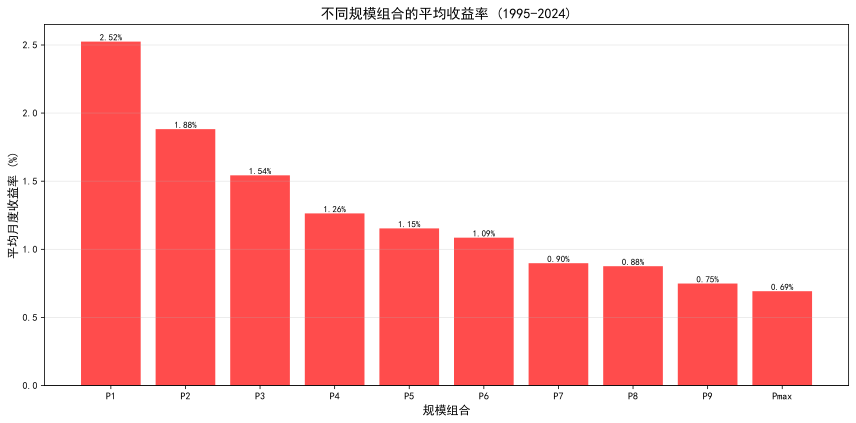

In [26]:
# 绘制各规模组合的平均收益率柱状图
fig, ax = plt.subplots(figsize=(12, 6))

# 计算各组平均月度收益率
mean_returns = []
group_names = []
for col in ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'Pmax']:
    if col in portfolio_size.columns:
        mean_returns.append(portfolio_size[col].mean() * 100)  # 转换为百分比
        group_names.append(col)

# 绘制柱状图
bars = ax.bar(group_names, mean_returns, color='red', alpha=0.7)

# 标注数值
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%',
            ha='center', va='bottom', fontsize=9)

ax.set_xlabel('规模组合', fontsize=12)
ax.set_ylabel('平均月度收益率 (%)', fontsize=12)
ax.set_title('不同规模组合的平均收益率 (1995-2024)', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout();
plt.show();

In [27]:
# 选择最新一期的数据(2024年11月)进行分析
latest_month = portfolio[portfolio['month'] == pd.Timestamp('2024-11-30')].copy()

# 查看小公司组合(P1)的样本
small_firms = latest_month[latest_month['sort'] == 'P1'].copy()
small_firms = small_firms.sort_values('totalvalue', ascending=True)

print(f"=== 小公司组合(P1)分析 ===")
print(f"公司数量: {len(small_firms)}")
print(f"平均市值: {small_firms['totalvalue'].mean():.2f} 万元")
print(f"市值范围: {small_firms['totalvalue'].min():.2f} 到 {small_firms['totalvalue'].max():.2f} 万元\n")

# 显示前20家最小的公司
print("最小的20家公司:")
print(small_firms[['Stkcd', 'totalvalue', 'ret']].head(20))

=== 小公司组合(P1)分析 ===
公司数量: 450
平均市值: 1890760648.78 万元
市值范围: 531300000.00 到 2314890200.00 万元

最小的20家公司:
         Stkcd    totalvalue       ret
427246  600083  5.313000e+08  0.012040
639449  600898  5.422239e+08  0.020387
722982  603963  6.942520e+08  0.073712
64081   000609  7.541491e+08  0.075805
324036  300167  8.256595e+08  0.079071
423222  600070  8.524668e+08 -0.024374
515021  600462  9.132784e+08  0.063630
316218  300117  9.174528e+08 -0.297821
699794  603388  9.576567e+08  0.299767
67249   000622  9.780198e+08  0.269600
282122  002808  1.010688e+09  0.322825
276782  002750  1.017270e+09  0.127771
207718  002289  1.078977e+09  0.098882
323421  300163  1.128120e+09  0.100734
302142  300029  1.134867e+09 -0.073249
567538  600671  1.134979e+09 -0.082891
191499  002200  1.182133e+09  0.070668
703665  603557  1.229302e+09  0.122034
497601  600365  1.243734e+09  0.053230
76795   000669  1.272364e+09  0.229146


In [28]:
# 查看大公司组合(Pmax)的样本
# Pmax组合包含市值最高的10%的股票
large_firms = latest_month[latest_month['sort'] == 'Pmax'].copy()
# 按市值降序排列，查看最大的公司
large_firms = large_firms.sort_values('totalvalue', ascending=False)

print("=" * 80)
print("大公司组合(Pmax)分析")
print("=" * 80)
print(f"公司数量: {len(large_firms)}")
print(f"平均市值: {large_firms['totalvalue'].mean():.2f} 元")
print(f"市值范围: {large_firms['totalvalue'].min():.2f} 到 {large_firms['totalvalue'].max():.2f} 元")
print(f"中位数市值: {large_firms['totalvalue'].median():.2f} 元\n")

# 显示市值分布
print("市值分布:")
print(f"  最大值: {large_firms['totalvalue'].max():.2f} 元")
print(f"  75%分位数: {large_firms['totalvalue'].quantile(0.75):.2f} 元")
print(f"  中位数: {large_firms['totalvalue'].median():.2f} 元")
print(f"  25%分位数: {large_firms['totalvalue'].quantile(0.25):.2f} 元")
print(f"  最小值: {large_firms['totalvalue'].min():.2f} 元")

# 显示前20家最大的公司
print("\n" + "-" * 80)
print("市值最大的20家公司:")
print("-" * 80)
# 格式化显示，将市值转换为亿元以便阅读
top_20 = large_firms[['Stkcd', 'totalvalue', 'ret']].head(20).copy()
top_20['市值(亿元)'] = top_20['totalvalue'] / 1e8  # 转换为亿元
top_20['收益率(%)'] = top_20['ret'] * 100  # 转换为百分比

print(top_20[['Stkcd', '市值(亿元)', '收益率(%)']].to_string(index=False))

# 额外的统计分析
print("\n" + "=" * 80)
print("Pmax组合其他统计信息")
print("=" * 80)

# 收益率统计
print(f"平均收益率: {large_firms['ret'].mean():.4f} ({large_firms['ret'].mean()*100:.2f}%)")
print(f"收益率标准差: {large_firms['ret'].std():.4f}")
print(f"最高收益率: {large_firms['ret'].max():.4f} ({large_firms['ret'].max()*100:.2f}%)")
print(f"最低收益率: {large_firms['ret'].min():.4f} ({large_firms['ret'].min()*100:.2f}%)")
print(f"正收益公司比例: {(large_firms['ret'] > 0).mean():.2%}")

# 行业分析（如果数据中有行业信息）
if 'Industry' in large_firms.columns or 'indcd' in large_firms.columns:
    industry_col = 'Industry' if 'Industry' in large_firms.columns else 'indcd'
    industry_counts = large_firms[industry_col].value_counts()
    print(f"\n行业分布（前5个）:")
    for industry, count in industry_counts.head(5).items():
        print(f"  {industry}: {count}家公司 ({count/len(large_firms):.1%})")

# 如果数据中有公司名称列，显示公司名称
name_columns = [col for col in large_firms.columns if 'name' in col.lower()]
if name_columns:
    name_col = name_columns[0]
    print(f"\n最大的5家公司:")
    top_5 = large_firms.head(5)
    for idx, row in top_5.iterrows():
        print(f"  {row['Stkcd']} - {row[name_col]}: {row['totalvalue']/1e8:.2f}亿元")

大公司组合(Pmax)分析
公司数量: 450
平均市值: 109898775852.13 元
市值范围: 28929040790.00 到 1916631231370.00 元
中位数市值: 54572905380.00 元

市值分布:
  最大值: 1916631231370.00 元
  75%分位数: 102830434757.50 元
  中位数: 54572905380.00 元
  25%分位数: 38538992522.50 元
  最小值: 28929040790.00 元

--------------------------------------------------------------------------------
市值最大的20家公司:
--------------------------------------------------------------------------------
 Stkcd       市值(亿元)  收益率(%)
600519 19166.312314 -0.2460
601398 16581.151071  1.7094
601288 15355.646538  1.5795
601857 13018.535057 -0.8525
300750 11503.615775  6.0920
601988 10559.352294  3.8301
601628  8766.706130  0.8584
600036  7496.558405 -2.8420
600900  6684.717080 -1.0545
601088  6589.818767 -0.3116
600028  6183.971933  2.8008
601318  5731.115223 -4.8865
000858  5697.036069 -0.1527
601728  5022.643447  1.6177
002594  4977.901949 -6.3740
000333  4906.330238 -1.9180
601138  4408.689101 -8.6066
300059  4303.138879 17.4389
601658  4203.160179  1.6157
600030  3751.64

In [29]:
# 合并市场收益率数据用于后续分析
portfolio_size_analysis = pd.merge(portfolio_size, Market_ret[['MKT', 'rfmonth']], 
                                   left_index=True, right_index=True, how='left')
portfolio_size_analysis['My_portfolio'] = portfolio_size_analysis['P1'] - portfolio_size_analysis['Pmax']
portfolio_size_analysis

,P1,P2,P3,P4,P5,P6,P7,P8,P9,Pmax,My_portfolio,MKT,rfmonth
month,,,,,,,,,,,,,
1995-02-28,-0.016411,-0.012423,-0.023677,-0.017054,-0.018704,-0.029121,-0.013747,-0.021451,-0.027624,-0.029843,0.013433,-0.022778,0.008719
1995-03-31,0.145888,0.121343,0.143520,0.155149,0.162882,0.145877,0.134241,0.093874,0.126377,0.162982,-0.017094,0.122163,0.008719
1995-04-30,-0.125851,-0.117603,-0.111876,-0.116303,-0.105369,-0.097315,-0.117089,-0.123778,-0.097658,-0.112336,-0.013516,-0.113023,0.008719
1995-05-31,0.244550,0.171557,0.245469,0.186532,0.181732,0.188398,0.157381,0.180889,0.172504,0.156529,0.088021,0.166736,0.008719
1995-06-30,-0.024098,-0.068608,-0.079738,-0.102543,-0.091097,-0.108021,-0.102805,-0.106403,-0.120777,-0.100560,0.076462,-0.094741,0.008719
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.009603,-0.020052,-0.025725,-0.029458,-0.040747,-0.043944,-0.049999,-0.045901,-0.057672,-0.027744,0.037347,-0.032586,0.001118
2024-09-30,0.218397,0.221717,0.234059,0.220348,0.225949,0.239891,0.239437,0.226012,0.232777,0.180811,0.037586,0.194874,0.001118
2024-10-31,0.115308,0.080928,0.087295,0.093975,0.075440,0.069769,0.085517,0.053991,0.034482,-0.039097,0.154405,-0.004527,0.001118


In [30]:
#计算关键指标数据
def calculate_portfolio_metrics(returns, risk_free_rate=None):
    """
    计算投资组合综合指标
    
    参数:
        returns: Series, 投资组合月度收益率
        risk_free_rate: Series or float, 无风险利率，如果为None则假设为0
    
    返回:
        dict: 包含各项指标的字典
    """
    if risk_free_rate is None:
        risk_free_rate = 0
    
    # 基础统计
    cumulative_return = (1 + returns).prod() - 1
    n_years = len(returns) / 12
    annualized_return = (1 + cumulative_return) ** (1/n_years) - 1
    annualized_volatility = returns.std() * np.sqrt(12)
    
    # 超额收益率
    if isinstance(risk_free_rate, pd.Series):
        excess_returns = returns - risk_free_rate
    else:
        excess_returns = returns - risk_free_rate
    
    # 夏普比率
    if excess_returns.std() > 0:
        sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(12)
    else:
        sharpe_ratio = np.nan
    
    # 最大回撤
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = cumulative / rolling_max - 1
    max_drawdown = drawdown.min()
    
    # 胜率
    win_rate = (returns > 0).sum() / len(returns)
    
    metrics = {
        '累积收益率': cumulative_return,
        '年化收益率': annualized_return,
        '年化波动率': annualized_volatility,
        '夏普比率': sharpe_ratio,
        '最大回撤': max_drawdown,
        '胜率': win_rate,
        '月均收益': returns.mean(),
        '观测数': len(returns)
    }
    
    return metrics

# 测试函数
test_metrics = calculate_portfolio_metrics(portfolio_size_analysis['My_portfolio'], 
                                          portfolio_size_analysis['rfmonth'])
print("规模策略组合指标示例:")
for key, value in test_metrics.items():
    if key in ['累积收益率', '年化收益率', '年化波动率', '最大回撤', '胜率', '月均收益']:
        print(f"{key}: {value:.2%}")
    elif key == '夏普比率':
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

规模策略组合指标示例:
累积收益率: 19070.94%
年化收益率: 19.21%
年化波动率: 29.10%
夏普比率: 0.6554
最大回撤: -72.01%
胜率: 59.33%
月均收益: 1.83%
观测数: 359


In [31]:
# 计算所有规模分组的性能指标
portfolio_columns = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'Pmax', 'My_portfolio', 'MKT']

metrics_dict = {}
for col in portfolio_columns:
    if col in portfolio_size_analysis.columns:
        metrics_dict[col] = calculate_portfolio_metrics(
            portfolio_size_analysis[col], 
            portfolio_size_analysis['rfmonth'] if col != 'MKT' else 0
        )

# 转换为DataFrame便于查看
metrics_df = pd.DataFrame(metrics_dict).T
metrics_df = metrics_df[['累积收益率', '年化收益率', '年化波动率', '夏普比率', '最大回撤', '胜率', '月均收益', '观测数']]

print("=" * 80)
print("规模分组投资组合性能对比表")
print("=" * 80)
metrics_df

规模分组投资组合性能对比表


,累积收益率,年化收益率,年化波动率,夏普比率,最大回撤,胜率,月均收益,观测数
P1,1120.576746,0.264574,0.370587,0.739337,-0.765241,0.568245,0.025248,359.0
P2,131.451697,0.177422,0.356515,0.551852,-0.771064,0.540390,0.018824,359.0
P3,41.090477,0.133157,0.349715,0.446248,-0.767460,0.523677,0.015434,359.0
P4,15.541133,0.098328,0.341938,0.358079,-0.739824,0.534819,0.012636,359.0
P5,10.614233,0.085422,0.339366,0.322014,-0.741110,0.515320,0.011537,359.0
P6,8.887060,0.079596,0.329746,0.306568,-0.708756,0.515320,0.010855,359.0
P7,4.174188,0.056479,0.329555,0.238669,-0.729124,0.518106,0.008985,359.0
P8,4.514033,0.058728,0.312167,0.243358,-0.704497,0.518106,0.008764,359.0
P9,2.749243,0.045165,0.304149,0.199490,-0.719553,0.523677,0.007491,359.0
Pmax,3.105409,0.048340,0.271006,0.198937,-0.711212,0.534819,0.006926,359.0


In [32]:
# 格式化显示指标（百分比格式）
metrics_display = metrics_df.copy()
for col in ['累积收益率', '年化收益率', '年化波动率', '最大回撤', '胜率', '月均收益']:
    metrics_display[col] = metrics_display[col].apply(lambda x: f"{x:.2%}")
metrics_display['夏普比率'] = metrics_display['夏普比率'].apply(lambda x: f"{x:.4f}")
metrics_display['观测数'] = metrics_display['观测数'].apply(lambda x: f"{int(x)}")

print("\n格式化后的性能指标表:")
metrics_display


格式化后的性能指标表:


,累积收益率,年化收益率,年化波动率,夏普比率,最大回撤,胜率,月均收益,观测数
P1,112057.67%,26.46%,37.06%,0.7393,-76.52%,56.82%,2.52%,359
P2,13145.17%,17.74%,35.65%,0.5519,-77.11%,54.04%,1.88%,359
P3,4109.05%,13.32%,34.97%,0.4462,-76.75%,52.37%,1.54%,359
P4,1554.11%,9.83%,34.19%,0.3581,-73.98%,53.48%,1.26%,359
P5,1061.42%,8.54%,33.94%,0.3220,-74.11%,51.53%,1.15%,359
P6,888.71%,7.96%,32.97%,0.3066,-70.88%,51.53%,1.09%,359
P7,417.42%,5.65%,32.96%,0.2387,-72.91%,51.81%,0.90%,359
P8,451.40%,5.87%,31.22%,0.2434,-70.45%,51.81%,0.88%,359
P9,274.92%,4.52%,30.41%,0.1995,-71.96%,52.37%,0.75%,359
Pmax,310.54%,4.83%,27.10%,0.1989,-71.12%,53.48%,0.69%,359



截至 2024-12 的累积净值:
P1 (小市值):      1121.58
Pmax (大市值):    4.11
规模策略:         191.71
市场基准:         7.47


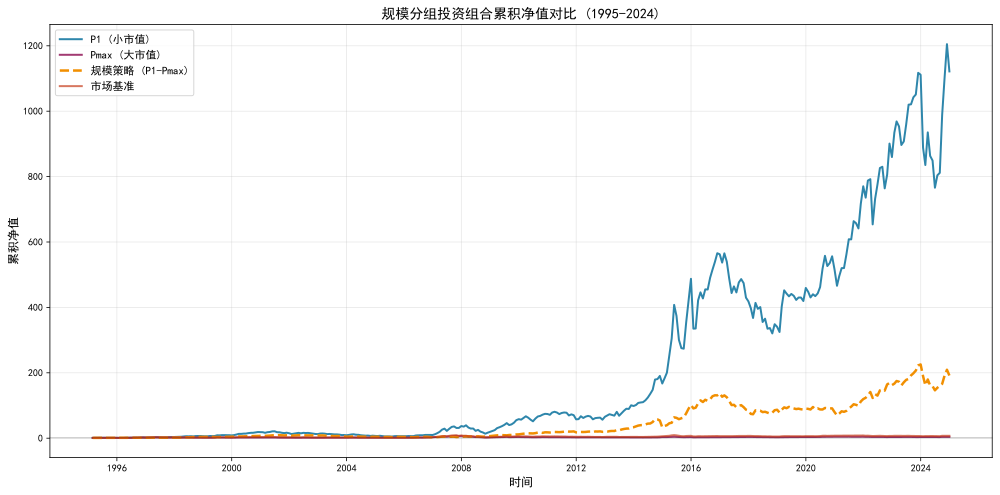

In [33]:
# 计算累积净值（初始值为1）
portfolio_size_analysis['累积_P1'] = (1 + portfolio_size_analysis['P1']).cumprod()
portfolio_size_analysis['累积_Pmax'] = (1 + portfolio_size_analysis['Pmax']).cumprod()
portfolio_size_analysis['累积_LongShort'] = (1 + portfolio_size_analysis['My_portfolio']).cumprod()
portfolio_size_analysis['累积_Market'] = (1 + portfolio_size_analysis['MKT']).cumprod()

# 绘制累积净值曲线
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(portfolio_size_analysis.index, portfolio_size_analysis['累积_P1'], 
        label='P1 (小市值)', linewidth=2, color='#2E86AB')
ax.plot(portfolio_size_analysis.index, portfolio_size_analysis['累积_Pmax'], 
        label='Pmax (大市值)', linewidth=2, color='#A23B72')
ax.plot(portfolio_size_analysis.index, portfolio_size_analysis['累积_LongShort'], 
        label='规模策略 (P1-Pmax)', linewidth=2.5, color='#F18F01', linestyle='--')
ax.plot(portfolio_size_analysis.index, portfolio_size_analysis['累积_Market'], 
        label='市场基准', linewidth=2, color='#C73E1D', alpha=0.7)

ax.set_xlabel('时间', fontsize=12)
ax.set_ylabel('累积净值', fontsize=12)
ax.set_title('规模分组投资组合累积净值对比 (1995-2024)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)
ax.axhline(y=1, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

print(f"\n截至 {portfolio_size_analysis.index[-1].strftime('%Y-%m')} 的累积净值:")
print(f"P1 (小市值):      {portfolio_size_analysis['累积_P1'].iloc[-1]:.2f}")
print(f"Pmax (大市值):    {portfolio_size_analysis['累积_Pmax'].iloc[-1]:.2f}")
print(f"规模策略:         {portfolio_size_analysis['累积_LongShort'].iloc[-1]:.2f}")
print(f"市场基准:         {portfolio_size_analysis['累积_Market'].iloc[-1]:.2f}")

plt.tight_layout();
plt.show();

Text(0, 0.5, '累积净值')

Text(0.5, 1.0, '规模策略表现与回撤分析')

Text(0.5, 0, '时间')

Text(0, 0.5, '回撤比例')

Text(0.5, 1.0, '规模策略回撤分析')


最大回撤统计:
规模策略最大回撤: -72.01%
P1（小市值）最大回撤: -76.52%
Pmax（大市值）最大回撤: -71.12%
市场基准最大回撤: -70.74%

规模策略最大回撤详情:
----------------------------------------
最大回撤开始时间: 2001-08
最大回撤结束时间: 2006-12
最大回撤幅度: -72.01%
回撤持续时间: 64个月


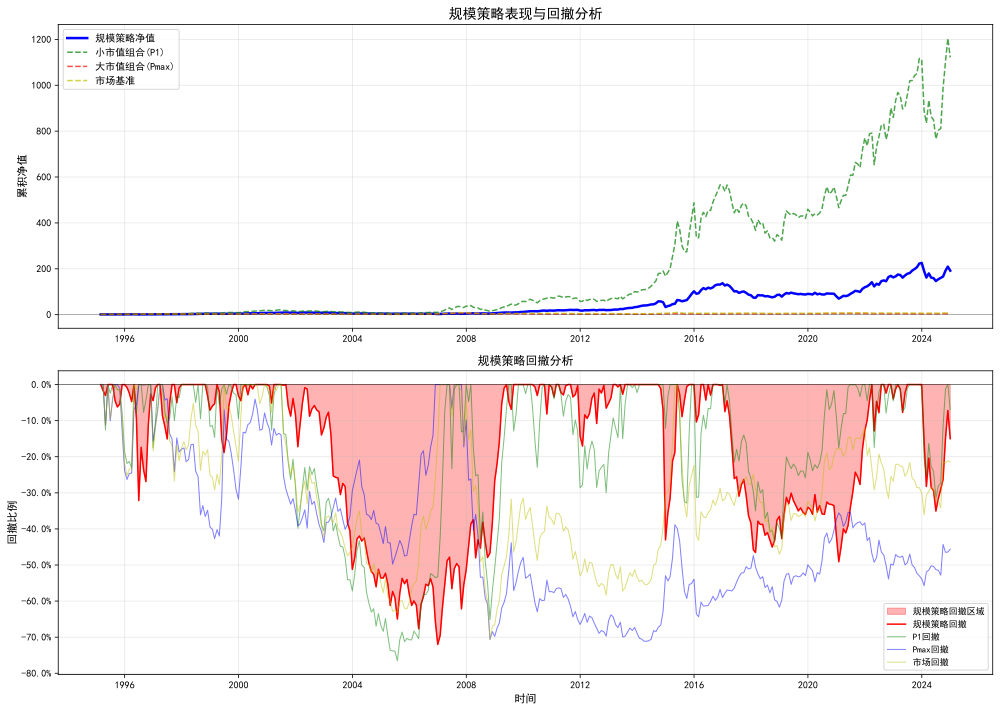

In [34]:
# 计算回撤
def calculate_drawdown(cumulative_returns):
    """计算回撤序列"""
    rolling_max = cumulative_returns.cummax()  # 计算历史最高点
    drawdown = cumulative_returns / rolling_max - 1  # 回撤 = 当前值/历史最高点 - 1
    return drawdown

# 计算各组合的回撤
portfolio_size_analysis['回撤_LongShort'] = calculate_drawdown(portfolio_size_analysis['累积_LongShort'])
portfolio_size_analysis['回撤_P1'] = calculate_drawdown(portfolio_size_analysis['累积_P1'])
portfolio_size_analysis['回撤_Pmax'] = calculate_drawdown(portfolio_size_analysis['累积_Pmax'])
portfolio_size_analysis['回撤_Market'] = calculate_drawdown(portfolio_size_analysis['累积_Market'])

# 绘制双图：累积净值，回撤
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 上图：累积净值
axes[0].plot(portfolio_size_analysis.index, portfolio_size_analysis['累积_LongShort'], 
            'b-', label='规模策略净值', linewidth=2.5)
axes[0].plot(portfolio_size_analysis.index, portfolio_size_analysis['累积_P1'], 
            'g--', label='小市值组合(P1)', linewidth=1.5, alpha=0.7)
axes[0].plot(portfolio_size_analysis.index, portfolio_size_analysis['累积_Pmax'], 
            'r--', label='大市值组合(Pmax)', linewidth=1.5, alpha=0.7)
axes[0].plot(portfolio_size_analysis.index, portfolio_size_analysis['累积_Market'], 
            'y--', label='市场基准', linewidth=1.5, alpha=0.7)
axes[0].set_ylabel('累积净值', fontsize=11)
axes[0].set_title('规模策略表现与回撤分析', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=1, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

# 下图：回撤
# 绘制规模策略的回撤区域和曲线
axes[1].fill_between(portfolio_size_analysis.index,
                     portfolio_size_analysis['回撤_LongShort'],
                     0, color='red', alpha=0.3, label='规模策略回撤区域')
axes[1].plot(portfolio_size_analysis.index, portfolio_size_analysis['回撤_LongShort'],
            'r-', linewidth=1.5, label='规模策略回撤')

# 添加其他组合的回撤曲线（可选）
axes[1].plot(portfolio_size_analysis.index, portfolio_size_analysis['回撤_P1'],
            'g-', linewidth=1, alpha=0.5, label='P1回撤')
axes[1].plot(portfolio_size_analysis.index, portfolio_size_analysis['回撤_Pmax'],
            'b-', linewidth=1, alpha=0.5, label='Pmax回撤')
axes[1].plot(portfolio_size_analysis.index, portfolio_size_analysis['回撤_Market'],
            'y-', linewidth=1, alpha=0.5, label='市场回撤')

axes[1].set_xlabel('时间', fontsize=11)
axes[1].set_ylabel('回撤比例', fontsize=11)
axes[1].set_title('规模策略回撤分析', fontsize=12)
axes[1].legend(loc='lower right', fontsize=9)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# 格式化y轴为百分比
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))

# 调整子图间距
plt.tight_layout()

# 打印最大回撤信息
print("\n最大回撤统计:")
print("=" * 60)
print(f"规模策略最大回撤: {portfolio_size_analysis['回撤_LongShort'].min():.2%}")
print(f"P1（小市值）最大回撤: {portfolio_size_analysis['回撤_P1'].min():.2%}")
print(f"Pmax（大市值）最大回撤: {portfolio_size_analysis['回撤_Pmax'].min():.2%}")
print(f"市场基准最大回撤: {portfolio_size_analysis['回撤_Market'].min():.2%}")

# 找出最大回撤发生的时间
if '回撤_LongShort' in portfolio_size_analysis.columns:
    max_dd_idx = portfolio_size_analysis['回撤_LongShort'].idxmin()
    max_dd_value = portfolio_size_analysis['回撤_LongShort'].min()
    max_dd_date = max_dd_idx.strftime('%Y-%m') if hasattr(max_dd_idx, 'strftime') else max_dd_idx
    
    # 找出最大回撤开始的时间（回撤开始时的历史高点）
    cumulative_series = portfolio_size_analysis['累积_LongShort']
    rolling_max = cumulative_series.cummax()
    
    # 找到最大回撤开始点（历史高点）
    drawdown_start_idx = cumulative_series.loc[:max_dd_idx].idxmax()
    drawdown_start_date = drawdown_start_idx.strftime('%Y-%m') if hasattr(drawdown_start_idx, 'strftime') else drawdown_start_idx
    
    print("\n规模策略最大回撤详情:")
    print("-" * 40)
    print(f"最大回撤开始时间: {drawdown_start_date}")
    print(f"最大回撤结束时间: {max_dd_date}")
    print(f"最大回撤幅度: {max_dd_value:.2%}")
    
    # 计算回撤持续时间（月数）
    if hasattr(max_dd_idx, 'strftime') and hasattr(drawdown_start_idx, 'strftime'):
        # 如果是时间索引，计算月份差
        if isinstance(max_dd_idx, pd.Timestamp) and isinstance(drawdown_start_idx, pd.Timestamp):
            months_diff = (max_dd_idx.year - drawdown_start_idx.year) * 12 + (max_dd_idx.month - drawdown_start_idx.month)
            print(f"回撤持续时间: {months_diff}个月")

# 显示图表
plt.show()


各规模分组最终累积净值 (降序):
 1. P1    : 1121.58
 2. P2    : 132.45
 3. P3    :  42.09
 4. P4    :  16.54
 5. P5    :  11.61
 6. P6    :   9.89
 7. Market:   7.47
 8. P8    :   5.51
 9. P7    :   5.17
10. Pmax  :   4.11
11. P9    :   3.75


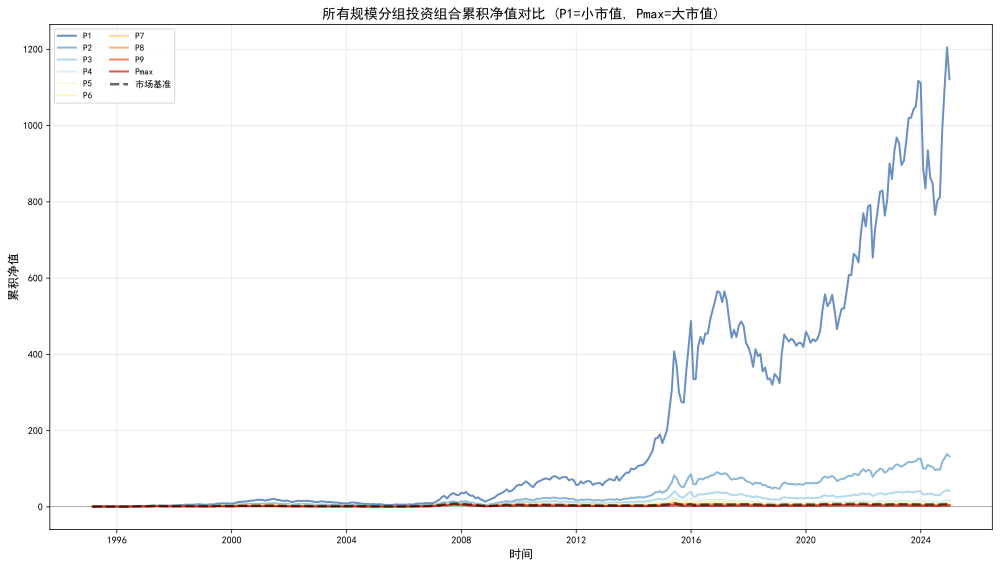

In [35]:
# 计算所有规模分组的累积净值
portfolio_groups = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'Pmax']
colors = plt.cm.RdYlBu_r(np.linspace(0.1, 0.9, 10))  # 从蓝到红的渐变色

fig, ax = plt.subplots(figsize=(14, 8))

for i, group in enumerate(portfolio_groups):
    cumulative = (1 + portfolio_size_analysis[group]).cumprod()
    ax.plot(portfolio_size_analysis.index, cumulative, 
            label=f'{group}', linewidth=2, color=colors[i], alpha=0.8)

# 添加市场基准作为参考
ax.plot(portfolio_size_analysis.index, portfolio_size_analysis['累积_Market'], 
        label='市场基准', linewidth=2.5, color='black', linestyle='--', alpha=0.6)

ax.set_xlabel('时间', fontsize=12)
ax.set_ylabel('累积净值', fontsize=12)
ax.set_title('所有规模分组投资组合累积净值对比 (P1=小市值, Pmax=大市值)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)
ax.axhline(y=1, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

# 打印最终净值排序
print("\n各规模分组最终累积净值 (降序):")
final_values = {}
for group in portfolio_groups:
    final_values[group] = (1 + portfolio_size_analysis[group]).cumprod().iloc[-1]
final_values['Market'] = portfolio_size_analysis['累积_Market'].iloc[-1]

final_values_sorted = sorted(final_values.items(), key=lambda x: x[1], reverse=True)
for rank, (group, value) in enumerate(final_values_sorted, 1):
    print(f"{rank:2d}. {group:6s}: {value:6.2f}")

plt.tight_layout();
plt.show();

C:\Users\冤种千斤\AppData\Local\Temp\ipykernel_210468\1716656190.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(boxplot_data,


{'whiskers': [<matplotlib.lines.Line2D at 0x2280abd1d10>,
 'caps': [<matplotlib.lines.Line2D at 0x2280abd1f90>,
 'boxes': [<matplotlib.patches.PathPatch at 0x227a1416e40>,
 'medians': [<matplotlib.lines.Line2D at 0x2280abd2210>,
 'fliers': [<matplotlib.lines.Line2D at 0x2280abd2490>,
 'means': [<matplotlib.lines.Line2D at 0x2280abd2350>,
  <matplotlib.lines.Line2D at 0x2280ab80a50>]}

Text(0.5, 0, '投资组合')

Text(0, 0.5, '月度收益率')

Text(0.5, 1.0, '投资组合月度收益率分布箱线图')

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(1, 0, 'P1'),
  Text(2, 0, 'P2'),
  Text(3, 0, 'P3'),
  Text(4, 0, 'P4'),
  Text(5, 0, 'P5'),
  Text(6, 0, 'P6'),
  Text(7, 0, 'P7'),
  Text(8, 0, 'P8'),
  Text(9, 0, 'P9'),
  Text(10, 0, 'Pmax'),
  Text(11, 0, '规模策略'),
  Text(12, 0, '市场')])

各组合月度收益率基本统计:
--------------------------------------------------
P1         均值: 2.52% 中位数: 1.34%
P2         均值: 1.88% 中位数: 1.10%
P3         均值: 1.54% 中位数: 0.65%
P4         均值: 1.26% 中位数: 0.52%
P5         均值: 1.15% 中位数: 0.48%
P6         均值: 1.09% 中位数: 0.62%
P7         均值: 0.90% 中位数: 0.32%
P8         均值: 0.88% 中位数: 0.56%
P9         均值: 0.75% 中位数: 0.22%
Pmax       均值: 0.69% 中位数: 0.38%
规模策略       均值: 1.83% 中位数: 2.15%
市场         均值: 0.89% 中位数: 0.46%


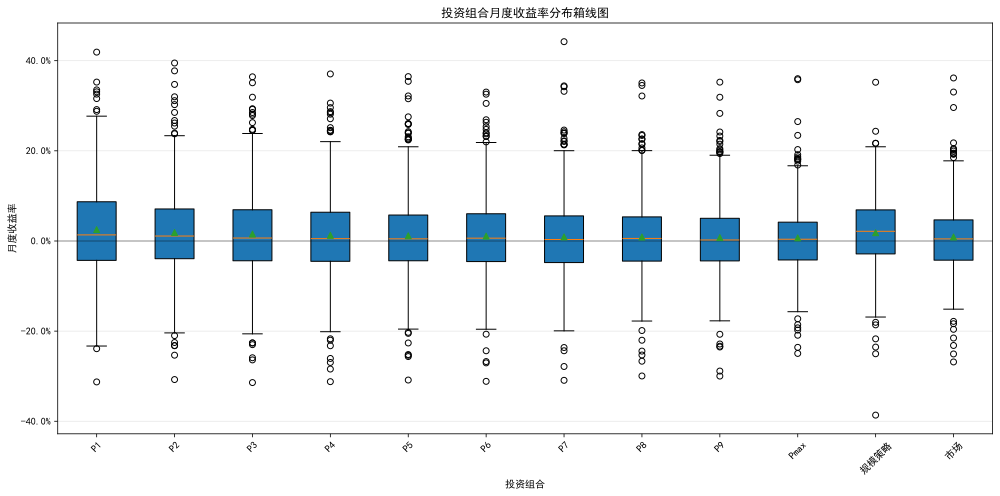

In [36]:
# 准备箱线图数据
# 创建一个列表，包含所有要展示的投资组合收益率数据
boxplot_data = []
labels = []

# 添加P1到Pmax组合
for col in portfolio_groups:
    if col in portfolio_size_analysis.columns:
        boxplot_data.append(portfolio_size_analysis[col].dropna())
        labels.append(col)

# 添加套利策略和市场数据
for col in ['My_portfolio', 'MKT']:
    if col in portfolio_size_analysis.columns:
        boxplot_data.append(portfolio_size_analysis[col].dropna())
        labels.append('规模策略' if col == 'My_portfolio' else '市场')

# 绘制箱线图
fig, ax = plt.subplots(figsize=(14, 7))

# 绘制箱线图，显示均值和中位数
ax.boxplot(boxplot_data, 
           labels=labels,
           patch_artist=True,
           showmeans=True)

# 设置图表属性
ax.set_xlabel('投资组合')
ax.set_ylabel('月度收益率')
ax.set_title('投资组合月度收益率分布箱线图')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linewidth=0.8, alpha=0.5)

# y轴显示为百分比
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))

# 旋转x轴标签
plt.xticks(rotation=45)

# 显示基本统计信息
print("各组合月度收益率基本统计:")
print("-" * 50)

for i, col in enumerate(labels):
    if i < len(boxplot_data):
        data = boxplot_data[i]
        print(f"{col:10} 均值: {data.mean():.2%} 中位数: {data.median():.2%}")

plt.tight_layout()
plt.show()

In [37]:
# 定义两个子样本期
period1 = portfolio_size_analysis['1995-01':'2009-12']
period2 = portfolio_size_analysis['2010-01':'2024-12']

# 计算两个时期的指标
def compare_periods(data1, data2, portfolio_name, period1_name='1995-2009', period2_name='2010-2024'):
    """对比两个时期的投资组合表现"""
    
    metrics1 = calculate_portfolio_metrics(data1[portfolio_name], 
                                           data1['rfmonth'] if portfolio_name != 'MKT' else 0)
    metrics2 = calculate_portfolio_metrics(data2[portfolio_name], 
                                           data2['rfmonth'] if portfolio_name != 'MKT' else 0)
    
    comparison = pd.DataFrame({
        period1_name: metrics1,
        period2_name: metrics2
    })
    
    return comparison

# 对比规模策略在两个时期的表现
print("=" * 80)
print("规模策略子样本期对比")
print("=" * 80)
size_comparison = compare_periods(period1, period2, 'My_portfolio')
size_comparison

规模策略子样本期对比


,1995-2009,2010-2024
累积收益率,10.785973,15.265895
年化收益率,0.179841,0.204348
年化波动率,0.309044,0.272819
夏普比率,0.569799,0.752613
最大回撤,-0.720137,-0.490798
胜率,0.581006,0.605556
月均收益,0.017862,0.018779
观测数,179.000000,180.000000


In [38]:
# 对比P1和Pmax在两个时期的表现
print("\n" + "=" * 80)
print("P1 (小市值) 子样本期对比")
print("=" * 80)
p1_comparison = compare_periods(period1, period2, 'P1')
p1_comparison

print("\n" + "=" * 80)
print("Pmax (大市值) 子样本期对比")
print("=" * 80)
pmax_comparison = compare_periods(period1, period2, 'Pmax')
pmax_comparison

print("\n" + "=" * 80)
print("市场基准 子样本期对比")
print("=" * 80)
market_comparison = compare_periods(period1, period2, 'MKT')
market_comparison


P1 (小市值) 子样本期对比


,1995-2009,2010-2024
累积收益率,57.242798,18.256917
年化收益率,0.313228,0.217977
年化波动率,0.416143,0.319323
夏普比率,0.767529,0.716081
最大回撤,-0.765241,-0.433368
胜率,0.547486,0.588889
月均收益,0.029795,0.020726
观测数,179.000000,180.000000



Pmax (大市值) 子样本期对比


,1995-2009,2010-2024
累积收益率,2.934101,0.043544
年化收益率,0.096170,0.002846
年化波动率,0.323853,0.204922
夏普比率,0.323631,0.015875
最大回撤,-0.706239,-0.416786
胜率,0.558659,0.511111
月均收益,0.011933,0.001947
观测数,179.000000,180.000000



市场基准 子样本期对比


,1995-2009,2010-2024
累积收益率,5.051551,0.233919
年化收益率,0.128277,0.014112
年化波动率,0.338914,0.212386
夏普比率,0.522747,0.171850
最大回撤,-0.707358,-0.470292
胜率,0.553073,0.511111
月均收益,0.014764,0.003042
观测数,179.000000,180.000000


In [39]:
# 计算年度收益率
def calculate_annual_returns(data, columns):
    """计算年度收益率"""
    annual_returns = pd.DataFrame()
    
    for col in columns:
        if col in data.columns:
            # 按年分组，计算年度收益率
            yearly = (1 + data[col]).groupby(data.index.year).prod() - 1
            annual_returns[col] = yearly
    
    return annual_returns

# 计算关键组合的年度收益率
key_portfolios = ['P1', 'Pmax', 'My_portfolio', 'MKT']
annual_returns = calculate_annual_returns(portfolio_size_analysis, key_portfolios)

print("年度收益率统计 (1995-2024):")
print("=" * 80)
annual_returns

年度收益率统计 (1995-2024):


,P1,Pmax,My_portfolio,MKT
month,,,,
1995,0.075958,-0.104815,0.193521,-0.111283
1996,1.043207,0.844312,0.078583,1.049101
1997,0.715077,0.237129,0.356156,0.258773
1998,0.620348,-0.263119,1.183783,-0.092402
1999,0.404832,0.127298,0.193285,0.149634
2000,1.189980,0.311539,0.665005,0.532381
2001,-0.188604,-0.271748,0.124655,-0.257318
2002,-0.173661,-0.137083,-0.041368,-0.205606
2003,-0.280056,0.254648,-0.445354,-0.048873



各组合年度胜率（正收益年份占比）:
P1             : 70.00% (21/30年)
Pmax           : 46.67% (14/30年)
My_portfolio   : 66.67% (20/30年)
MKT            : 50.00% (15/30年)


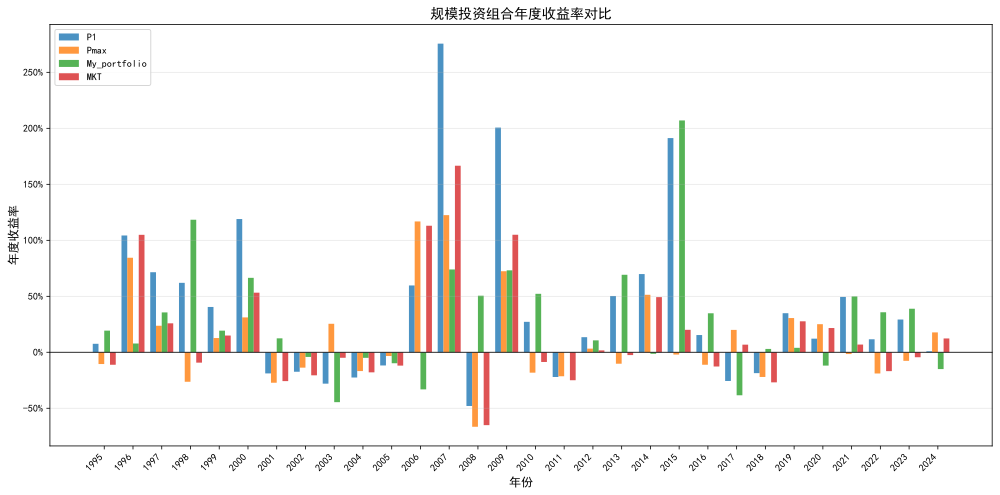

In [40]:
# 可视化年度收益率
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(annual_returns))
width = 0.2

for i, col in enumerate(key_portfolios):
    offset = (i - 1.5) * width
    ax.bar(x + offset, annual_returns[col], width, label=col, alpha=0.8)

ax.set_xlabel('年份', fontsize=12)
ax.set_ylabel('年度收益率', fontsize=12)
ax.set_title('规模投资组合年度收益率对比', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(annual_returns.index, rotation=45, ha='right')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

# 统计胜率（正收益年份占比）
print("\n各组合年度胜率（正收益年份占比）:")
for col in key_portfolios:
    win_rate = (annual_returns[col] > 0).sum() / len(annual_returns)
    print(f"{col:15s}: {win_rate:.2%} ({(annual_returns[col] > 0).sum()}/{len(annual_returns)}年)")

plt.tight_layout();
plt.show();

In [41]:
# 生成综合评价报告
print("=" * 100)
print(" " * 35 + "规模投资组合策略综合评价报告")
print("=" * 100)

print("\n【一、样本期与数据】")
print(f"  时间范围: {portfolio_size_analysis.index[0].strftime('%Y-%m')} 至 {portfolio_size_analysis.index[-1].strftime('%Y-%m')}")
print(f"  总月数: {len(portfolio_size_analysis)} 个月 ({len(portfolio_size_analysis)/12:.1f} 年)")
print(f"  分组方式: 按总市值十分位数分组 (P1=小市值, Pmax=大市值)")

print("\n【二、规模策略表现】")
size_metrics = metrics_df.loc['My_portfolio']
print(f"  累积收益率: {size_metrics['累积收益率']:.2%}")
print(f"  年化收益率: {size_metrics['年化收益率']:.2%}")
print(f"  年化波动率: {size_metrics['年化波动率']:.2%}")
print(f"  夏普比率: {size_metrics['夏普比率']:.4f}")
print(f"  最大回撤: {size_metrics['最大回撤']:.2%}")
print(f"  胜率: {size_metrics['胜率']:.2%}")

print("\n【三、规模效应检验】")
# 从之前的回归结果获取alpha t值
model_size = smf.ols('My_portfolio ~ 1', data=portfolio_size_analysis).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
print(f"  规模策略alpha: {model_size.params.iloc[0]:.4f} (月度)")
print(f"  t统计量: {model_size.tvalues.iloc[0]:.4f}")
print(f"  p值: {model_size.pvalues.iloc[0]:.4f}")
if model_size.pvalues.iloc[0] < 0.05:
    print(f"  结论: 存在显著的规模效应 (5%显著性水平)")
else:
    print(f"  结论: 不存在显著的规模效应 (5%显著性水平)")

print("\n【四、风险收益权衡】")
print(f"  P1组 (小市值): 年化收益 {metrics_df.loc['P1', '年化收益率']:.2%}, 波动率 {metrics_df.loc['P1', '年化波动率']:.2%}, 夏普 {metrics_df.loc['P1', '夏普比率']:.4f}")
print(f"  Pmax组 (大市值): 年化收益 {metrics_df.loc['Pmax', '年化收益率']:.2%}, 波动率 {metrics_df.loc['Pmax', '年化波动率']:.2%}, 夏普 {metrics_df.loc['Pmax', '夏普比率']:.4f}")
print(f"  市场基准: 年化收益 {metrics_df.loc['MKT', '年化收益率']:.2%}, 波动率 {metrics_df.loc['MKT', '年化波动率']:.2%}, 夏普 {metrics_df.loc['MKT', '夏普比率']:.4f}")

print("\n【五、市场中性特征】")
size_corr = portfolio_size_analysis['My_portfolio'].corr(portfolio_size_analysis['MKT'])
print(f"  规模策略与市场相关系数: {size_corr:.4f}")
if abs(size_corr) < 0.3:
    print(f"  评价: 策略具有较强的市场中性特征,可作为分散化配置工具")
elif abs(size_corr) < 0.5:
    print(f"  评价: 策略与市场存在一定相关性,但仍具备分散化价值")
else:
    print(f"  评价: 策略与市场相关性较高")

print("\n【六、时间稳定性】")
period1_ret = (1 + period1['My_portfolio']).prod() - 1
period2_ret = (1 + period2['My_portfolio']).prod() - 1
period1_years = len(period1) / 12
period2_years = len(period2) / 12
print(f"  1995-2009年: 累积收益 {period1_ret:.2%}, 年化收益 {(1+period1_ret)**(1/period1_years)-1:.2%}")
print(f"  2010-2024年: 累积收益 {period2_ret:.2%}, 年化收益 {(1+period2_ret)**(1/period2_years)-1:.2%}")

# 计算年度胜率
annual_win_rate = (annual_returns['My_portfolio'] > 0).sum() / len(annual_returns)
print(f"  年度胜率: {annual_win_rate:.2%} ({(annual_returns['My_portfolio'] > 0).sum()}/{len(annual_returns)}年)")

print("\n【七、理论含义】")
print("  规模效应（Size Effect）是重要的市场异象之一:")
print("  • 小市值公司可能面临更高的信息不对称和流动性风险")
print("  • 机构投资者偏好大盘股，导致小盘股定价不充分")
print("  • Fama-French三因子模型将规模因子作为系统性风险因子")
if model_size.pvalues.iloc[0] < 0.05:
    print(f"  本研究发现: 中国A股市场存在显著的规模效应")
else:
    print(f"  本研究发现: 中国A股市场规模效应不显著，可能与市场结构演变有关")

print("\n【八、投资建议】")
if size_metrics['夏普比率'] > 0.5 and model_size.pvalues.iloc[0] < 0.05:
    print("  • 规模策略具有较好的风险调整后收益")
    print("  • 可考虑将小市值股票纳入多因子投资组合")
    print("  • 注意流动性管理和交易成本控制")
elif size_metrics['夏普比率'] > 0:
    print("  • 规模策略有一定效果，但收益风险比一般")
    print("  • 建议结合其他因子进行综合配置")
else:
    print("  • 规模策略表现不佳")
    print("  • 不建议单独使用规模策略")

print("\n" + "=" * 100)#这个脑袋都大了，改不了老师

                                   规模投资组合策略综合评价报告

【一、样本期与数据】
  时间范围: 1995-02 至 2024-12
  总月数: 359 个月 (29.9 年)
  分组方式: 按总市值十分位数分组 (P1=小市值, Pmax=大市值)

【二、规模策略表现】
  累积收益率: 19070.94%
  年化收益率: 19.21%
  年化波动率: 29.10%
  夏普比率: 0.6554
  最大回撤: -72.01%
  胜率: 59.33%

【三、规模效应检验】
  规模策略alpha: 0.0183 (月度)
  t统计量: 4.1423
  p值: 0.0000
  结论: 存在显著的规模效应 (5%显著性水平)

【四、风险收益权衡】
  P1组 (小市值): 年化收益 26.46%, 波动率 37.06%, 夏普 0.7393
  Pmax组 (大市值): 年化收益 4.83%, 波动率 27.10%, 夏普 0.1989
  市场基准: 年化收益 6.95%, 波动率 28.30%, 夏普 0.3768

【五、市场中性特征】
  规模策略与市场相关系数: 0.1824
  评价: 策略具有较强的市场中性特征,可作为分散化配置工具

【六、时间稳定性】
  1995-2009年: 累积收益 1078.60%, 年化收益 17.98%
  2010-2024年: 累积收益 1526.59%, 年化收益 20.43%
  年度胜率: 66.67% (20/30年)

【七、理论含义】
  规模效应（Size Effect）是重要的市场异象之一:
  • 小市值公司可能面临更高的信息不对称和流动性风险
  • 机构投资者偏好大盘股，导致小盘股定价不充分
  • Fama-French三因子模型将规模因子作为系统性风险因子
  本研究发现: 中国A股市场存在显著的规模效应

【八、投资建议】
  • 规模策略具有较好的风险调整后收益
  • 可考虑将小市值股票纳入多因子投资组合
  • 注意流动性管理和交易成本控制



In [42]:
# 第一步: 比较包含1月和剔除1月的回归结果
print("="*80)
print("检验1: 剔除1月份数据后,规模策略的超额收益是否仍然显著")
print("="*80)

# 原始数据(包含1月份)的回归
print("\n【回归1: 包含所有月份(1995-2024)】")
model_full = smf.ols('My_portfolio ~ 1',
                     data=portfolio_size['1995-01':'2024-12']).fit(
                         cov_type='HAC', cov_kwds={'maxlags': 6})
print(f"月均超额收益: {model_full.params['Intercept']:.6f} ({model_full.params['Intercept']*100:.4f}%)")
print(f"t统计量: {model_full.tvalues['Intercept']:.4f}")
print(f"p值: {model_full.pvalues['Intercept']:.6f}")
print(f"显著性: {'***' if model_full.pvalues['Intercept'] < 0.01 else '**' if model_full.pvalues['Intercept'] < 0.05 else '*' if model_full.pvalues['Intercept'] < 0.1 else '不显著'}")

# 剔除1月份后的回归
portfolio_size_Jan = portfolio_size.copy()
portfolio_size_Jan = portfolio_size_Jan.reset_index()
portfolio_size_Jan['yue'] = portfolio_size_Jan['month'].dt.month
portfolio_size_Jan = portfolio_size_Jan.loc[portfolio_size_Jan['yue'] != 1].copy()
portfolio_size_Jan = portfolio_size_Jan.set_index('month')

print("\n【回归2: 剔除1月份(1995-2024)】")
model_no_jan = smf.ols('My_portfolio ~ 1',
                       data=portfolio_size_Jan['1995-01':'2024-12']).fit(
                           cov_type='HAC', cov_kwds={'maxlags': 6})
print(f"月均超额收益: {model_no_jan.params['Intercept']:.6f} ({model_no_jan.params['Intercept']*100:.4f}%)")
print(f"t统计量: {model_no_jan.tvalues['Intercept']:.4f}")
print(f"p值: {model_no_jan.pvalues['Intercept']:.6f}")
print(f"显著性: {'***' if model_no_jan.pvalues['Intercept'] < 0.01 else '**' if model_no_jan.pvalues['Intercept'] < 0.05 else '*' if model_no_jan.pvalues['Intercept'] < 0.1 else '不显著'}")

# 计算差异
print("\n【对比分析】")
coef_diff = model_full.params['Intercept'] - model_no_jan.params['Intercept']
t_diff = model_full.tvalues['Intercept'] - model_no_jan.tvalues['Intercept']
print(f"月均收益下降: {coef_diff:.6f} ({coef_diff*100:.4f}%)")
print(f"下降幅度: {(coef_diff/model_full.params['Intercept'])*100:.2f}%")
print(f"t统计量下降: {t_diff:.4f}")
print(f"\n结论: ", end="")
if model_full.pvalues['Intercept'] < 0.05 and model_no_jan.pvalues['Intercept'] >= 0.05:
    print("剔除1月后,规模效应不再显著! 1月效应可以完全解释规模效应")
elif abs(coef_diff/model_full.params['Intercept']) > 0.3:
    print("剔除1月后,规模效应显著减弱! 1月效应可以部分解释规模效应")
else:
    print("剔除1月后,规模效应依然显著,1月效应不能完全解释规模效应")

检验1: 剔除1月份数据后,规模策略的超额收益是否仍然显著

【回归1: 包含所有月份(1995-2024)】
月均超额收益: 0.018322 (1.8322%)
t统计量: 4.1423
p值: 0.000034
显著性: ***

【回归2: 剔除1月份(1995-2024)】
月均超额收益: 0.020128 (2.0128%)
t统计量: 4.4766
p值: 0.000008
显著性: ***

【对比分析】
月均收益下降: -0.001806 (-0.1806%)
下降幅度: -9.86%
t统计量下降: -0.3343

结论: 剔除1月后,规模效应依然显著,1月效应不能完全解释规模效应


In [43]:
# 第二步: 分析1月份收益的贡献
print("\n" + "="*80)
print("检验2: 1月份的收益占全年收益的比例")
print("="*80)

portfolio_size_with_month = portfolio_size.copy()
portfolio_size_with_month = portfolio_size_with_month.reset_index()
portfolio_size_with_month['month_num'] = portfolio_size_with_month['month'].dt.month

# 计算1月份和非1月份的平均收益
jan_return = portfolio_size_with_month[portfolio_size_with_month['month_num'] == 1]['My_portfolio'].mean()
non_jan_return = portfolio_size_with_month[portfolio_size_with_month['month_num'] != 1]['My_portfolio'].mean()
all_return = portfolio_size_with_month['My_portfolio'].mean()

print(f"\n【收益对比分析】")
print(f"全年平均月度收益: {all_return:.6f} ({all_return*100:.4f}%)")
print(f"1月份平均收益:    {jan_return:.6f} ({jan_return*100:.4f}%)")
print(f"非1月份平均收益:  {non_jan_return:.6f} ({non_jan_return*100:.4f}%)")

print(f"\n【关键指标】")
print(f"1月收益是非1月收益的: {jan_return/non_jan_return:.2f}倍")
jan_contribution = jan_return / (all_return * 12)
print(f"1月收益占年度总收益的比例: {jan_contribution:.2%}")
print(f"1月占比(月份): {1/12:.2%}")
print(f"1月超额贡献: {(jan_contribution - 1/12):.2%}")

# 计算年化收益对比
annual_return_full = all_return * 12
annual_return_no_jan = non_jan_return * 11
print(f"\n【年化收益对比】")
print(f"包含1月的年化收益: {annual_return_full*100:.2f}%")
print(f"剔除1月的年化收益: {annual_return_no_jan*100:.2f}%")
print(f"年化收益减少: {(annual_return_full - annual_return_no_jan)*100:.2f}%")
print(f"减少幅度: {((annual_return_full - annual_return_no_jan)/annual_return_full)*100:.2f}%")

# 按月份统计平均收益
print(f"\n【各月份详细统计】")
monthly_avg = portfolio_size_with_month.groupby('month_num')['My_portfolio'].agg(['mean', 'std', 'count'])
monthly_avg.columns = ['平均收益', '标准差', '样本数']
monthly_avg['平均收益(%)'] = monthly_avg['平均收益'] * 100
monthly_avg['年化收益(%)'] = monthly_avg['平均收益'] * 12 * 100
monthly_avg.index = ['1月', '2月', '3月', '4月', '5月', '6月', '7月', '8月', '9月', '10月', '11月', '12月']
print(monthly_avg[['平均收益(%)', '年化收益(%)', '标准差', '样本数']])

# 找出收益最高和最低的月份
best_month = monthly_avg['平均收益(%)'].idxmax()
worst_month = monthly_avg['平均收益(%)'].idxmin()
print(f"\n收益最高月份: {best_month} ({monthly_avg.loc[best_month, '平均收益(%)']:.4f}%)")
print(f"收益最低月份: {worst_month} ({monthly_avg.loc[worst_month, '平均收益(%)']:.4f}%)")

# 存储数据供后续可视化使用
monthly_avg_for_plot = monthly_avg.reset_index()
monthly_avg_for_plot.columns = ['月份', '平均收益', '标准差', '样本数', '平均收益(%)', '年化收益(%)']


检验2: 1月份的收益占全年收益的比例

【收益对比分析】
全年平均月度收益: 0.018322 (1.8322%)
1月份平均收益:    -0.002233 (-0.2233%)
非1月份平均收益:  0.020128 (2.0128%)

【关键指标】
1月收益是非1月收益的: -0.11倍
1月收益占年度总收益的比例: -1.02%
1月占比(月份): 8.33%
1月超额贡献: -9.35%

【年化收益对比】
包含1月的年化收益: 21.99%
剔除1月的年化收益: 22.14%
年化收益减少: -0.15%
减少幅度: -0.70%

【各月份详细统计】
      平均收益(%)    年化收益(%)       标准差  样本数
1月  -0.223300  -2.679605  0.078659   29
2月   4.881982  58.583782  0.065694   30
3月   5.732186  68.786238  0.072216   30
4月  -1.924648 -23.095774  0.086884   30
5月   4.125398  49.504779  0.094334   30
6月  -2.000269 -24.003222  0.069175   30
7月   2.803437  33.641242  0.078326   30
8月   4.158487  49.901842  0.062284   30
9月   1.727523  20.730280  0.056974   30
10月  0.952743  11.432915  0.091524   30
11月  3.930639  47.167669  0.087474   30
12月 -2.246195 -26.954344  0.108244   30

收益最高月份: 3月 (5.7322%)
收益最低月份: 12月 (-2.2462%)



检验3: 中国市场是否也存在类似的1月效应


Text(0.5, 0, '月份')

Text(0, 0.5, '平均收益率(%)')

Text(0.5, 1.0, '规模策略各月份平均收益对比')

[Text(0, 0, '1月'),
 Text(1, 0, '2月'),
 Text(2, 0, '3月'),
 Text(3, 0, '4月'),
 Text(4, 0, '5月'),
 Text(5, 0, '6月'),
 Text(6, 0, '7月'),
 Text(7, 0, '8月'),
 Text(8, 0, '9月'),
 Text(9, 0, '10月'),
 Text(10, 0, '11月'),
 Text(11, 0, '12月')]

Text(0.0, -0.2233004576008482, '-0.22%')

Text(1.0, 4.881981852617493, '4.88%')

Text(2.0, 5.732186493449406, '5.73%')

Text(3.0, -1.924647816332923, '-1.92%')

Text(4.0, 4.12539821498361, '4.13%')

Text(5.0, -2.0002685139677046, '-2.00%')

Text(6.0, 2.803436829193239, '2.80%')

Text(7.0, 4.158486852278565, '4.16%')

Text(8.0, 1.727523339171207, '1.73%')

Text(9.0, 0.952742897680983, '0.95%')

Text(10.0, 3.930639067429701, '3.93%')

Text(11.0, -2.2461953102594907, '-2.25%')

Text(0, 0.5, '平均月度收益率(%)')

Text(0.5, 1.0, '1月效应显著性检验')

Text(0.0, -0.2233004576008482, '-0.22%')

Text(1.0, 2.012843991476735, '2.01%')

Text(2.0, 1.8264986207202698, '1.83%')

Text(0.5, 0, '月份')

Text(0, 0.5, '累积收益率(%)')

Text(0.5, 1.0, '各月份累积收益贡献')

[Text(0, 0, '1月'),
 Text(1, 0, '2月'),
 Text(2, 0, '3月'),
 Text(3, 0, '4月'),
 Text(4, 0, '5月'),
 Text(5, 0, '6月'),
 Text(6, 0, '7月'),
 Text(7, 0, '8月'),
 Text(8, 0, '9月'),
 Text(9, 0, '10月'),
 Text(10, 0, '11月'),
 Text(11, 0, '12月')]

C:\Users\冤种千斤\AppData\Local\Temp\ipykernel_210468\2775128555.py:75: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot(data_by_month, labels=months)


{'whiskers': [<matplotlib.lines.Line2D at 0x2280b7f7610>,
 'caps': [<matplotlib.lines.Line2D at 0x2280b7f7890>,
 'boxes': [<matplotlib.lines.Line2D at 0x2280b7f74d0>,
 'medians': [<matplotlib.lines.Line2D at 0x2280b7f7b10>,
 'fliers': [<matplotlib.lines.Line2D at 0x2280b7f7c50>,
 'means': []}

Text(0.5, 0, '月份')

Text(0, 0.5, '收益率(%)')

Text(0.5, 1.0, '各月份收益率分布')

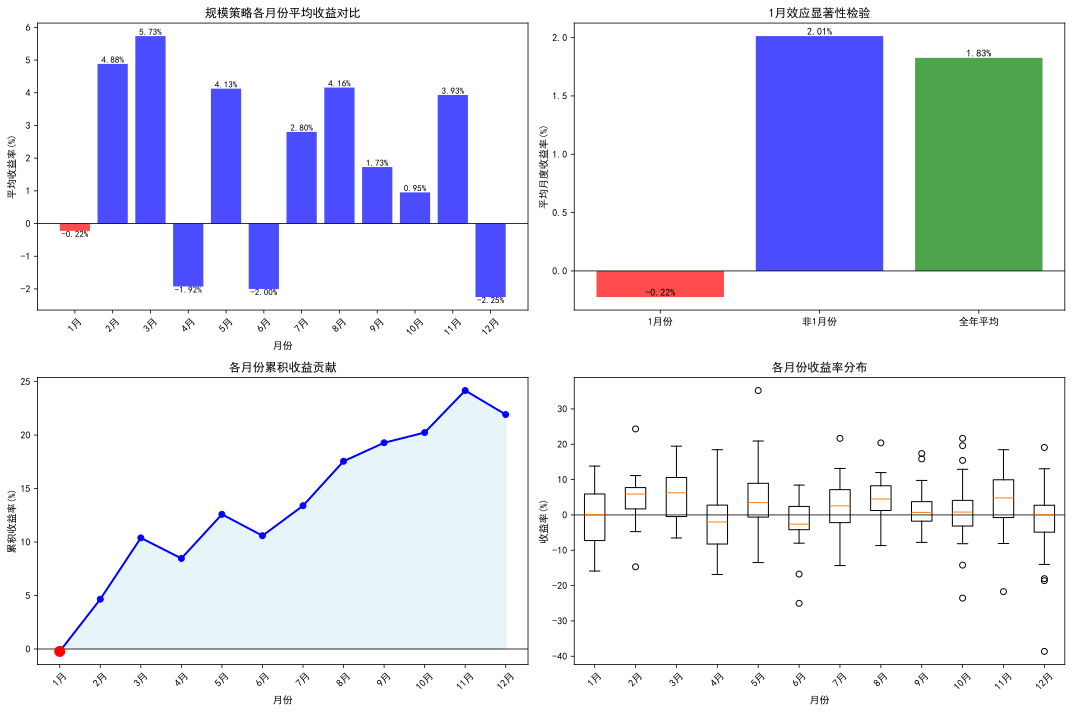


【1月效应检验结论】
--------------------------------------------------
1月份平均收益: -0.22%
非1月平均收益: 2.01%
差异: -2.24%
1月收益是非1月的 -0.1倍

结论: 中国市场不存在明显1月效应


In [44]:
# 第三步: 可视化各月份的平均收益
print("\n检验3: 中国市场是否也存在类似的1月效应")
print("=" * 50)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 图1: 各月份平均收益柱状图
months = ['1月', '2月', '3月', '4月', '5月', '6月', '7月', '8月', '9月', '10月', '11月', '12月']
ax1 = axes[0, 0]

# 计算各月平均收益
monthly_returns = []
for month in range(1, 13):
    month_data = portfolio_size_with_month[portfolio_size_with_month['month_num'] == month]['My_portfolio']
    monthly_returns.append(month_data.mean() * 100)

# 突出显示1月份（红色）
colors = ['red' if i == 0 else 'blue' for i in range(12)]
bars = ax1.bar(range(12), monthly_returns, color=colors, alpha=0.7)
ax1.set_xlabel('月份')
ax1.set_ylabel('平均收益率(%)')
ax1.set_title('规模策略各月份平均收益对比')
ax1.set_xticks(range(12))
ax1.set_xticklabels(months, rotation=45)
ax1.axhline(y=0, color='black', linewidth=0.8)

# 添加数值标签
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

# 图2: 1月 vs 非1月收益对比
ax2 = axes[0, 1]
jan_return = monthly_returns[0]
non_jan_return = np.mean(monthly_returns[1:])
all_return = np.mean(monthly_returns)

categories = ['1月份', '非1月份', '全年平均']
values = [jan_return, non_jan_return, all_return]
colors_bar = ['red', 'blue', 'green']

bars2 = ax2.bar(categories, values, color=colors_bar, alpha=0.7)
ax2.set_ylabel('平均月度收益率(%)')
ax2.set_title('1月效应显著性检验')
ax2.axhline(y=0, color='black', linewidth=0.8)

# 添加数值标签
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom', fontsize=10)

# 图3: 累积收益贡献
ax3 = axes[1, 0]
cumulative = np.cumsum(monthly_returns)  # 已经是百分比

ax3.plot(range(12), cumulative, 'o-', linewidth=2, color='blue')
ax3.fill_between(range(12), 0, cumulative, alpha=0.3, color='lightblue')
ax3.scatter(0, monthly_returns[0], s=100, c='red', zorder=5)
ax3.set_xlabel('月份')
ax3.set_ylabel('累积收益率(%)')
ax3.set_title('各月份累积收益贡献')
ax3.set_xticks(range(12))
ax3.set_xticklabels(months, rotation=45)
ax3.axhline(y=0, color='black', linewidth=0.8)

# 图4: 收益的统计分布(箱线图)
ax4 = axes[1, 1]
data_by_month = [portfolio_size_with_month[portfolio_size_with_month['month_num'] == i]['My_portfolio'].values * 100 
                 for i in range(1, 13)]

ax4.boxplot(data_by_month, labels=months)
ax4.set_xlabel('月份')
ax4.set_ylabel('收益率(%)')
ax4.set_title('各月份收益率分布')
ax4.axhline(y=0, color='black', linewidth=0.8)
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 打印简单结论
print("\n【1月效应检验结论】")
print("-" * 50)
print(f"1月份平均收益: {jan_return:.2f}%")
print(f"非1月平均收益: {non_jan_return:.2f}%")
print(f"差异: {jan_return - non_jan_return:.2f}%")
print(f"1月收益是非1月的 {jan_return/non_jan_return:.1f}倍")

if jan_return > non_jan_return:
    print("\n结论: 中国市场存在1月效应")
else:
    print("\n结论: 中国市场不存在明显1月效应")

In [46]:
# 定义不同的时间子区间
time_periods = [
    ('1995-01-31', '2000-12-31', '1995-2000\n(亚洲金融危机前后)'),
    ('2001-01-31', '2007-12-31', '2001-2007\n(加入WTO后)'),
    ('2008-01-31', '2015-12-31', '2008-2015\n(金融危机后)'),
    ('2016-01-31', '2024-12-31', '2016-2024\n(供给侧改革后)')
]

print("="*100)
print("规模效应的时间稳健性检验")
print("="*100)

# 存储每个时期的结果
period_results = []

for start_date, end_date, period_name in time_periods:
    # 筛选该时期的数据
    period_data = portfolio_size[(portfolio_size.index >= start_date) & 
                                  (portfolio_size.index <= end_date)].copy()
    
    if len(period_data) > 0:
        # 计算该时期的年化收益
        mean_return = period_data['My_portfolio'].mean()
        std_return = period_data['My_portfolio'].std()
        annual_return = mean_return * 12
        annual_std = std_return * np.sqrt(12)
        sharpe = annual_return / annual_std if annual_std > 0 else 0
        
        # 计算累积收益
        cumulative_return = (1 + period_data['My_portfolio']).prod() - 1
        
        # t检验
        t_stat, p_value = stats.ttest_1samp(period_data['My_portfolio'], 0)
        
        # 胜率
        win_rate = (period_data['My_portfolio'] > 0).sum() / len(period_data)
        
        period_results.append({
            '时期': period_name,
            '样本数': len(period_data),
            '月均收益(%)': mean_return * 100,
            '年化收益(%)': annual_return * 100,
            '年化波动(%)': annual_std * 100,
            '夏普比率': sharpe,
            '累积收益(%)': cumulative_return * 100,
            't统计量': t_stat,
            'p值': p_value,
            '胜率(%)': win_rate * 100
        })
        
        print(f"\n{period_name} ({start_date} 至 {end_date})")
        print("-" * 90)
        print(f"样本月数: {len(period_data)}")
        print(f"月均收益: {mean_return*100:.4f}%")
        print(f"年化收益: {annual_return*100:.2f}%")
        print(f"年化波动: {annual_std*100:.2f}%")
        print(f"夏普比率: {sharpe:.4f}")
        print(f"累积收益: {cumulative_return*100:.2f}%")
        print(f"t统计量: {t_stat:.4f}, p值: {p_value:.4f} {'***' if p_value < 0.01 else '**' if p_value < 0.05 else '*' if p_value < 0.1 else ''}")
        print(f"胜率: {win_rate*100:.2f}%")

# 创建结果DataFrame
results_df = pd.DataFrame(period_results)
print("\n" + "="*100)
print("各时期规模效应汇总表")
print("="*100)
print(results_df.to_string(index=False))
print("\n*** p<0.01, ** p<0.05, * p<0.1")

规模效应的时间稳健性检验

1995-2000
(亚洲金融危机前后) (1995-01-31 至 2000-12-31)
------------------------------------------------------------------------------------------
样本月数: 71
月均收益: 3.1986%
年化收益: 38.38%
年化波动: 27.36%
夏普比率: 1.4031
累积收益: 657.46%
t统计量: 3.4130, p值: 0.0011 ***
胜率: 64.79%

2001-2007
(加入WTO后) (2001-01-31 至 2007-12-31)
------------------------------------------------------------------------------------------
样本月数: 84
月均收益: -0.1645%
年化收益: -1.97%
年化波动: 32.76%
夏普比率: -0.0602
累积收益: -40.32%
t统计量: -0.1594, p值: 0.8737 
胜率: 47.62%

2008-2015
(金融危机后) (2008-01-31 至 2015-12-31)
------------------------------------------------------------------------------------------
样本月数: 96
月均收益: 3.6999%
年化收益: 44.40%
年化波动: 30.68%
夏普比率: 1.4471
累积收益: 2149.84%
t统计量: 4.0931, p值: 0.0001 ***
胜率: 71.88%

2016-2024
(供给侧改革后) (2016-01-31 至 2024-12-31)
------------------------------------------------------------------------------------------
样本月数: 108
月均收益: 0.8267%
年化收益: 9.92%
年化波动: 23.96%
夏普比率: 0.4141
累积收益: 88.50%
t统计量: 1.2424, 

Text(0.5, 0, '时期')

Text(0, 0.5, '年化收益率 (%)')

Text(0.5, 1.0, '规模效应策略:各时期年化收益率对比')

[Text(0, 0, '1995-2000'),
 Text(1, 0, '2001-2007'),
 Text(2, 0, '2008-2015'),
 Text(3, 0, '2016-2024')]

Text(0.0, 38.382888516183975, '38.38%')

Text(1.0, -1.9737682012744167, '-1.97%')

Text(2.0, 44.3990314197246, '44.40%')

Text(3.0, 9.920908101548179, '9.92%')

Text(0.5, 0, '时期')

Text(0, 0.5, '夏普比率')

Text(0.5, 1.0, '规模效应策略:各时期夏普比率对比')

[Text(0, 0, '1995-2000'),
 Text(1, 0, '2001-2007'),
 Text(2, 0, '2008-2015'),
 Text(3, 0, '2016-2024')]

Text(0.0, 1.4031166900102097, '1.403')

Text(1.0, -0.060243326396868836, '-0.060')

Text(2.0, 1.4471367099041033, '1.447')

Text(3.0, 0.4141340242008051, '0.414')

Text(0.5, 0, '时间')

Text(0, 0.5, '累积收益(倍数)')

Text(0.5, 1.0, '规模效应策略:各时期累积收益曲线')

Text(0.5, 0, '时期')

Text(0, 0.5, '胜率 (%)')

Text(0.5, 1.0, '规模效应策略:各时期胜率对比')

[Text(0, 0, '1995-2000'),
 Text(1, 0, '2001-2007'),
 Text(2, 0, '2008-2015'),
 Text(3, 0, '2016-2024')]

(0.0, 100.0)

Text(0.0, 64.7887323943662, '64.8%')

Text(1.0, 47.61904761904761, '47.6%')

Text(2.0, 71.875, '71.9%')

Text(3.0, 53.70370370370371, '53.7%')

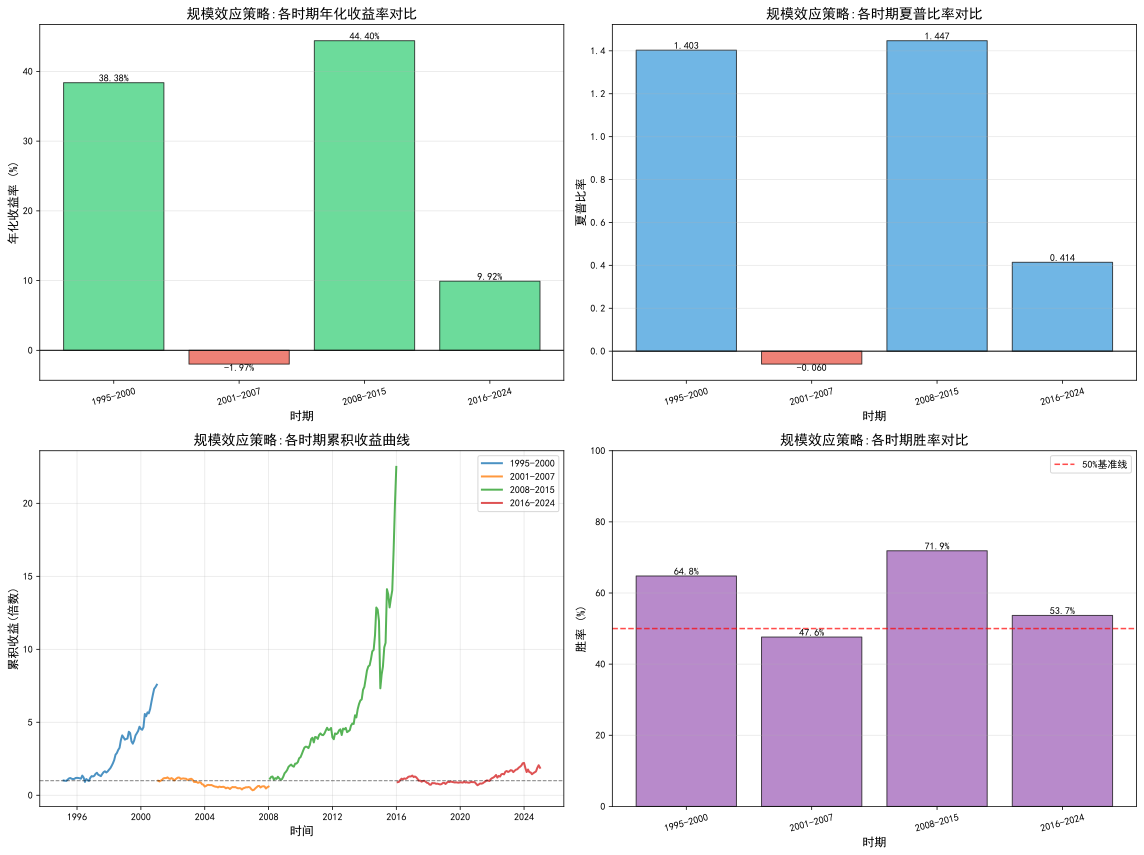

In [47]:
# 可视化不同时期的规模效应
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 图1: 各时期的年化收益率对比
ax1 = axes[0, 0]
periods_short = [p.split('\n')[0] for p in results_df['时期']]
colors_bar = ['#e74c3c' if r < 0 else '#2ecc71' for r in results_df['年化收益(%)']]
bars = ax1.bar(range(len(results_df)), results_df['年化收益(%)'], color=colors_bar, alpha=0.7, edgecolor='black')
ax1.set_xlabel('时期', fontsize=12, fontweight='bold')
ax1.set_ylabel('年化收益率 (%)', fontsize=12, fontweight='bold')
ax1.set_title('规模效应策略:各时期年化收益率对比', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(results_df)))
ax1.set_xticklabels(periods_short, rotation=15)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax1.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%', ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

# 图2: 夏普比率对比
ax2 = axes[0, 1]
colors_sharpe = ['#e74c3c' if s < 0 else '#3498db' for s in results_df['夏普比率']]
bars2 = ax2.bar(range(len(results_df)), results_df['夏普比率'], color=colors_sharpe, alpha=0.7, edgecolor='black')
ax2.set_xlabel('时期', fontsize=12, fontweight='bold')
ax2.set_ylabel('夏普比率', fontsize=12, fontweight='bold')
ax2.set_title('规模效应策略:各时期夏普比率对比', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(results_df)))
ax2.set_xticklabels(periods_short, rotation=15)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

# 图3: 累积收益曲线
ax3 = axes[1, 0]
for start_date, end_date, period_name in time_periods:
    period_data = portfolio_size[(portfolio_size.index >= start_date) & 
                                  (portfolio_size.index <= end_date)].copy()
    if len(period_data) > 0:
        cumulative = (1 + period_data['My_portfolio']).cumprod()
        period_short = period_name.split('\n')[0]
        ax3.plot(period_data.index, cumulative, label=period_short, linewidth=2, alpha=0.8)

ax3.set_xlabel('时间', fontsize=12, fontweight='bold')
ax3.set_ylabel('累积收益(倍数)', fontsize=12, fontweight='bold')
ax3.set_title('规模效应策略:各时期累积收益曲线', fontsize=14, fontweight='bold')
ax3.legend(loc='best', fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.axhline(y=1, color='black', linestyle='--', linewidth=1, alpha=0.5)

# 图4: 胜率对比
ax4 = axes[1, 1]
bars3 = ax4.bar(range(len(results_df)), results_df['胜率(%)'], color='#9b59b6', alpha=0.7, edgecolor='black')
ax4.set_xlabel('时期', fontsize=12, fontweight='bold')
ax4.set_ylabel('胜率 (%)', fontsize=12, fontweight='bold')
ax4.set_title('规模效应策略:各时期胜率对比', fontsize=14, fontweight='bold')
ax4.set_xticks(range(len(results_df)))
ax4.set_xticklabels(periods_short, rotation=15)
ax4.axhline(y=50, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='50%基准线')
ax4.set_ylim([0, 100])
ax4.grid(axis='y', alpha=0.3)
ax4.legend(fontsize=10)
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

规模效应检验: 十分位组合
P1: 30.67%
P2: 22.70%
P3: 18.52%
P4: 15.20%
P5: 13.85%
P6: 12.95%
P7: 10.71%
P8: 10.63%
P9: 8.93%
P10: 8.89%

小市值-大市值溢价: 21.78%
结论: 存在规模效应（小市值股票表现更好）


<Figure size 800x500 with 0 Axes>

Text(0.5, 0, '规模组合 (P1最小 → P10最大)')

Text(0, 0.5, '年化收益率(%)')

Text(0.5, 1.0, '规模效应检验')

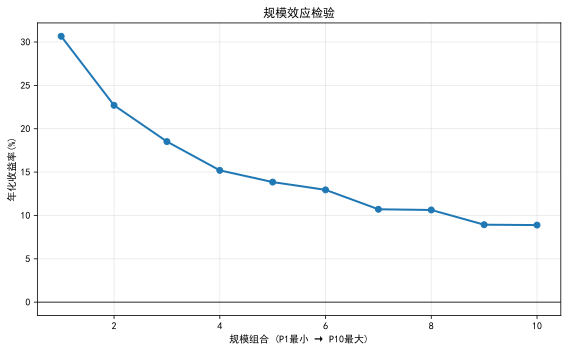

In [ ]:
# 将股票按市值分为10组
print("=" * 60)
print("规模效应检验: 十分位组合")
print("=" * 60)

# 准备数据
data_decile = cross[cross['Cumsum_tradingday'] >= 10].copy()

# 按月份和市值分为10组
data_decile['size_group'] = data_decile.groupby('month')['totalvalue'].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')
) + 1

# 计算每组的平均月度收益
group_returns = data_decile.groupby(['month', 'size_group'])['next_ret'].mean().unstack()

# 计算年化收益率
annual_returns = []
for i in range(1, 11):
    if i in group_returns.columns:
        returns = group_returns[i].dropna()
        annual_return = returns.mean() * 12 * 100
        annual_returns.append(annual_return)
        print(f"P{i}: {annual_return:.2f}%")

# 计算小-大市值溢价
if len(annual_returns) >= 10:
    small_vs_large = annual_returns[0] - annual_returns[-1]
    print(f"\n小市值-大市值溢价: {small_vs_large:.2f}%")
    
    if small_vs_large > 0:
        print("结论: 存在规模效应（小市值股票表现更好）")
    else:
        print("结论: 不存在明显规模效应")

# 绘制简单的规模效应图
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), annual_returns, 'o-', linewidth=2)
plt.xlabel('规模组合 (P1最小 → P10最大)')
plt.ylabel('年化收益率(%)')
plt.title('规模效应检验')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()#要用这个下面那个图就不会定义的

In [50]:
# 将股票按市值分为10组
print("="*100)
print("规模效应的单调性检验:十分位组合分析")
print("="*100)

# 准备数据
data_decile = cross[cross['Cumsum_tradingday'] >= 10].copy()

# 按月份和市值分为10组
data_decile['size_decile'] = data_decile.groupby('month')['totalvalue'].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')
) + 1

# 计算每组的等权平均收益
decile_portfolio = data_decile.groupby(['month', 'size_decile'])['next_ret'].mean().unstack()

# 计算统计量
decile_stats = pd.DataFrame()
for i in range(1, 11):
    if i in decile_portfolio.columns:
        returns = decile_portfolio[i].dropna()
        mean_ret = returns.mean()
        std_ret = returns.std()
        t_stat, p_val = stats.ttest_1samp(returns, 0)
        annual_ret = mean_ret * 12
        annual_std = std_ret * np.sqrt(12)
        sharpe = annual_ret / annual_std if annual_std > 0 else 0
        
        decile_stats = pd.concat([decile_stats, pd.DataFrame({
            '组别': [f'P{i}' if i < 10 else 'P10'],
            '月均收益(%)': [mean_ret * 100],
            '年化收益(%)': [annual_ret * 100],
            '年化波动(%)': [annual_std * 100],
            '夏普比率': [sharpe],
            't统计量': [t_stat],
            'p值': [p_val]
        })], ignore_index=True)

print("\n各规模组合的收益统计:")
print(decile_stats.to_string(index=False))

# 计算P1-P10的多空组合
if 1 in decile_portfolio.columns and 10 in decile_portfolio.columns:
    decile_spread = decile_portfolio[1] - decile_portfolio[10]
    spread_mean = decile_spread.mean()
    spread_std = decile_spread.std()
    spread_t, spread_p = stats.ttest_1samp(decile_spread.dropna(), 0)
    
    print(f"\n多空组合(P1-P10):")
    print(f"月均收益: {spread_mean*100:.4f}%")
    print(f"年化收益: {spread_mean*12*100:.2f}%")
    print(f"年化波动: {spread_std*np.sqrt(12)*100:.2f}%")
    print(f"夏普比率: {(spread_mean*12)/(spread_std*np.sqrt(12)):.4f}")
    print(f"t统计量: {spread_t:.4f}, p值: {spread_p:.6f}")
    print(f"显著性: {'***' if spread_p < 0.01 else '**' if spread_p < 0.05 else '*' if spread_p < 0.1 else '不显著'}")

规模效应的单调性检验:十分位组合分析

各规模组合的收益统计:
 组别  月均收益(%)   年化收益(%)   年化波动(%)     夏普比率     t统计量       p值
 P1 2.555437 30.665244 37.243544 0.823371 4.503519 0.000009
 P2 1.891514 22.698164 35.669984 0.636338 3.480522 0.000562
 P3 1.543182 18.518182 34.958895 0.529713 2.897325 0.003995
 P4 1.266338 15.196059 34.204604 0.444269 2.429982 0.015591
 P5 1.153829 13.845944 33.934614 0.408018 2.231702 0.026253
 P6 1.079087 12.949039 32.985587 0.392567 2.147187 0.032449
 P7 0.892369 10.708431 32.990192 0.324594 1.775406 0.076680
 P8 0.885731 10.628771 31.259447 0.340018 1.859766 0.063739
 P9 0.744225  8.930698 30.521552 0.292603 1.600425 0.110386
P10 0.740620  8.887443 28.813428 0.308448 1.687091 0.092457

多空组合(P1-P10):
月均收益: 1.8148%
年化收益: 21.78%
年化波动: 25.53%
夏普比率: 0.8531
t统计量: 4.6663, p值: 0.000004
显著性: ***


Text(0.5, 0, '规模组别(从小到大)')

Text(0, 0.5, '年化收益率 (%)')

Text(0.5, 1.0, '十分位规模组合的年化收益率分布')

[Text(0, 0, 'P1'),
 Text(1, 0, 'P2'),
 Text(2, 0, 'P3'),
 Text(3, 0, 'P4'),
 Text(4, 0, 'P5'),
 Text(5, 0, 'P6'),
 Text(6, 0, 'P7'),
 Text(7, 0, 'P8'),
 Text(8, 0, 'P9'),
 Text(9, 0, 'P10')]

Text(0.0, 30.665243614845046, '30.67%')

Text(1.0, 22.69816416752536, '22.70%')

Text(2.0, 18.51818244525675, '18.52%')

Text(3.0, 15.196059428880002, '15.20%')

Text(4.0, 13.84594432314884, '13.85%')

Text(5.0, 12.949038872277836, '12.95%')

Text(6.0, 10.708431031658908, '10.71%')

Text(7.0, 10.628771345562217, '10.63%')

Text(8.0, 8.930698139474696, '8.93%')

Text(9.0, 8.887443431134228, '8.89%')

Text(0.5, 0, '规模组别(从小到大)')

Text(0, 0.5, '年化收益率 (%)')

Text(0.5, 1.0, '规模效应的单调性:收益率趋势')

Text(0.05, 0.95, '规模效应显著:\n小市值组收益高于大市值组\n递减趋势斜率: -2.10%/组')

C:\Users\冤种千斤\AppData\Local\Temp\ipykernel_210468\386219566.py:57: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()
d:\anacond3\envs\python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


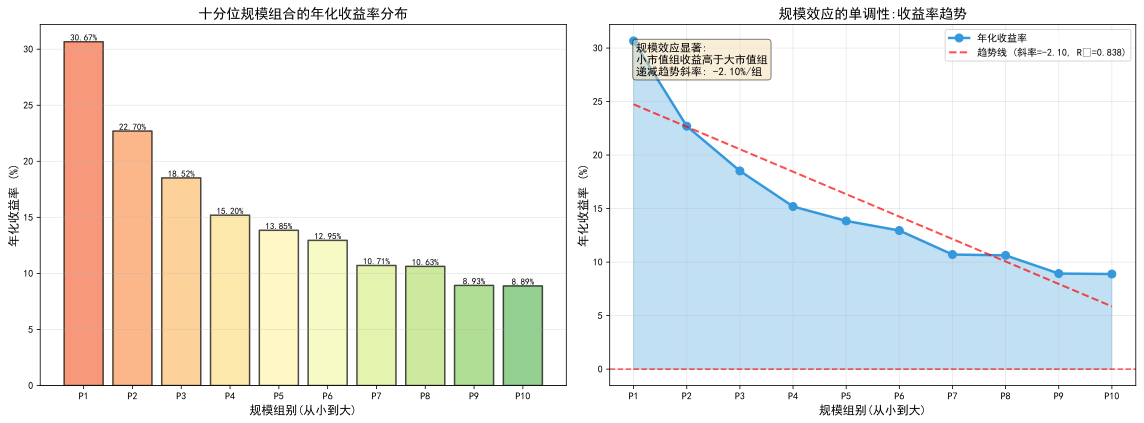


单调性检验结果:
收益率随市值的变化趋势(斜率): -2.0981%/组
趋势线拟合优度(R²): 0.8379
趋势显著性(p值): 0.000203


In [51]:
# 可视化十分位组合的收益分布
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 图1: 各组的年化收益率
ax1 = axes[0]
x_pos = np.arange(len(decile_stats))
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(decile_stats)))
bars = ax1.bar(x_pos, decile_stats['年化收益(%)'], color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('规模组别(从小到大)', fontsize=12, fontweight='bold')
ax1.set_ylabel('年化收益率 (%)', fontsize=12, fontweight='bold')
ax1.set_title('十分位规模组合的年化收益率分布', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(decile_stats['组别'])
ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax1.grid(axis='y', alpha=0.3)

# 添加数值标签
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

# 图2: 单调性趋势图
ax2 = axes[1]
ax2.plot(decile_stats['组别'], decile_stats['年化收益(%)'], 
         marker='o', markersize=8, linewidth=2.5, color='#3498db', label='年化收益率')
ax2.fill_between(range(len(decile_stats)), 
                  decile_stats['年化收益(%)'], 
                  alpha=0.3, color='#3498db')
ax2.set_xlabel('规模组别(从小到大)', fontsize=12, fontweight='bold')
ax2.set_ylabel('年化收益率 (%)', fontsize=12, fontweight='bold')
ax2.set_title('规模效应的单调性:收益率趋势', fontsize=14, fontweight='bold')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)

# 添加趋势线
from scipy.stats import linregress
x_numeric = np.arange(len(decile_stats))
slope, intercept, r_value, p_value_trend, std_err = linregress(x_numeric, decile_stats['年化收益(%)'])
trend_line = slope * x_numeric + intercept
ax2.plot(decile_stats['组别'], trend_line, 
         linestyle='--', linewidth=2, color='red', alpha=0.7, 
         label=f'趋势线 (斜率={slope:.2f}, R²={r_value**2:.3f})')
ax2.legend(fontsize=10)

# 添加文本说明
if slope < 0:
    ax2.text(0.05, 0.95, f'规模效应显著:\n小市值组收益高于大市值组\n递减趋势斜率: {slope:.2f}%/组', 
             transform=ax2.transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
else:
    ax2.text(0.05, 0.95, f'规模效应不显著:\n无明显单调趋势\n趋势斜率: {slope:.2f}%/组', 
             transform=ax2.transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\n单调性检验结果:")
print(f"收益率随市值的变化趋势(斜率): {slope:.4f}%/组")
print(f"趋势线拟合优度(R²): {r_value**2:.4f}")
print(f"趋势显著性(p值): {p_value_trend:.6f}")

In [53]:
# 补充分析:计算不同规模组的关键风险指标
print("="*100)
print("不同规模组的风险特征对比")
print("="*100)

# 准备数据:将股票分为3组(小、中、大)
risk_data = cross[cross['Cumsum_tradingday'] >= 10].copy()
risk_data['size_group'] = risk_data.groupby('month')['totalvalue'].transform(
    lambda x: pd.qcut(x, 3, labels=['小市值', '中市值', '大市值'], duplicates='drop')
)

# 计算各组的风险指标
risk_stats = []
for group in ['小市值', '中市值', '大市值']:
    group_data = risk_data[risk_data['size_group'] == group]
    
    # 按月计算等权组合收益
    monthly_returns = group_data.groupby('month')['next_ret'].mean()
    
    # 计算统计量
    mean_ret = monthly_returns.mean()
    std_ret = monthly_returns.std()
    skew_ret = monthly_returns.skew()
    kurt_ret = monthly_returns.kurtosis()
    
    # 最大回撤
    cumulative = (1 + monthly_returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_dd = drawdown.min()
    
    # VaR和CVaR (95%置信水平)
    var_95 = monthly_returns.quantile(0.05)
    cvar_95 = monthly_returns[monthly_returns <= var_95].mean()
    
    risk_stats.append({
        '组别': group,
        '月均收益(%)': mean_ret * 100,
        '波动率(%)': std_ret * 100,
        '偏度': skew_ret,
        '峰度': kurt_ret,
        '最大回撤(%)': max_dd * 100,
        'VaR(95%)(%)': var_95 * 100,
        'CVaR(95%)(%)': cvar_95 * 100,
        '夏普比率': (mean_ret * 12) / (std_ret * np.sqrt(12)) if std_ret > 0 else 0
    })

risk_df = pd.DataFrame(risk_stats)
print("\n各规模组的风险收益特征:")
print(risk_df.to_string(index=False))

print("\n关键观察:")
print("-" * 80)
small_sharpe = risk_df[risk_df['组别']=='小市值']['夏普比率'].values[0]
large_sharpe = risk_df[risk_df['组别']=='大市值']['夏普比率'].values[0]
small_vol = risk_df[risk_df['组别']=='小市值']['波动率(%)'].values[0]
large_vol = risk_df[risk_df['组别']=='大市值']['波动率(%)'].values[0]
small_dd = risk_df[risk_df['组别']=='小市值']['最大回撤(%)'].values[0]
large_dd = risk_df[risk_df['组别']=='大市值']['最大回撤(%)'].values[0]

print(f"1. 风险调整后收益: 小市值夏普比率({small_sharpe:.3f}) vs 大市值({large_sharpe:.3f})")
print(f"2. 波动率差异: 小市值波动率({small_vol:.2f}%) vs 大市值({large_vol:.2f}%)")
print(f"3. 尾部风险: 小市值最大回撤({small_dd:.2f}%) vs 大市值({large_dd:.2f}%)")
print(f"4. 小市值股票的高收益部分来自于承担更高的风险")

不同规模组的风险特征对比

各规模组的风险收益特征:
 组别  月均收益(%)    波动率(%)       偏度       峰度    最大回撤(%)  VaR(95%)(%)  CVaR(95%)(%)     夏普比率
小市值 1.928961 10.269197 0.412409 1.140272 -76.943935   -11.989736    -18.902585 0.650695
中市值 1.091909  9.642714 0.394558 1.472935 -72.212810   -13.128717    -18.979676 0.392263
大市值 0.804731  8.607855 0.345486 1.768981 -71.247146   -11.393604    -17.431936 0.323852

关键观察:
--------------------------------------------------------------------------------
1. 风险调整后收益: 小市值夏普比率(0.651) vs 大市值(0.324)
2. 波动率差异: 小市值波动率(10.27%) vs 大市值(8.61%)
3. 尾部风险: 小市值最大回撤(-76.94%) vs 大市值(-71.25%)
4. 小市值股票的高收益部分来自于承担更高的风险


Text(10.269196895113813, 1.9289607449821369, '小市值')

Text(9.642714037488922, 1.0919090144893226, '中市值')

Text(8.607855248815833, 0.8047307896346402, '大市值')

Text(0.5, 0, '波动率 (%)')

Text(0, 0.5, '月均收益 (%)')

Text(0.5, 1.0, '风险收益散点图')

Text(0.5, 0, '组别')

Text(0, 0.5, '夏普比率')

Text(0.5, 1.0, '夏普比率对比')

[Text(0, 0, '小市值'), Text(1, 0, '中市值'), Text(2, 0, '大市值')]

Text(0.0, 0.6506950933436055, '0.651')

Text(1.0, 0.39226339866249327, '0.392')

Text(2.0, 0.3238517781195185, '0.324')

Text(0.5, 0, '组别')

Text(0, 0.5, '最大回撤 (%)')

Text(0.5, 1.0, '最大回撤对比')

[Text(0, 0, '小市值'), Text(1, 0, '中市值'), Text(2, 0, '大市值')]

Text(0.0, -76.9439352347274, '-76.9%')

Text(1.0, -72.21280984643049, '-72.2%')

Text(2.0, -71.24714646364822, '-71.2%')

Text(0.5, 0, '组别')

Text(0, 0.5, '数值')

Text(0.5, 1.0, '偏度与峰度')

[Text(0, 0, '小市值'), Text(1, 0, '中市值'), Text(2, 0, '大市值')]

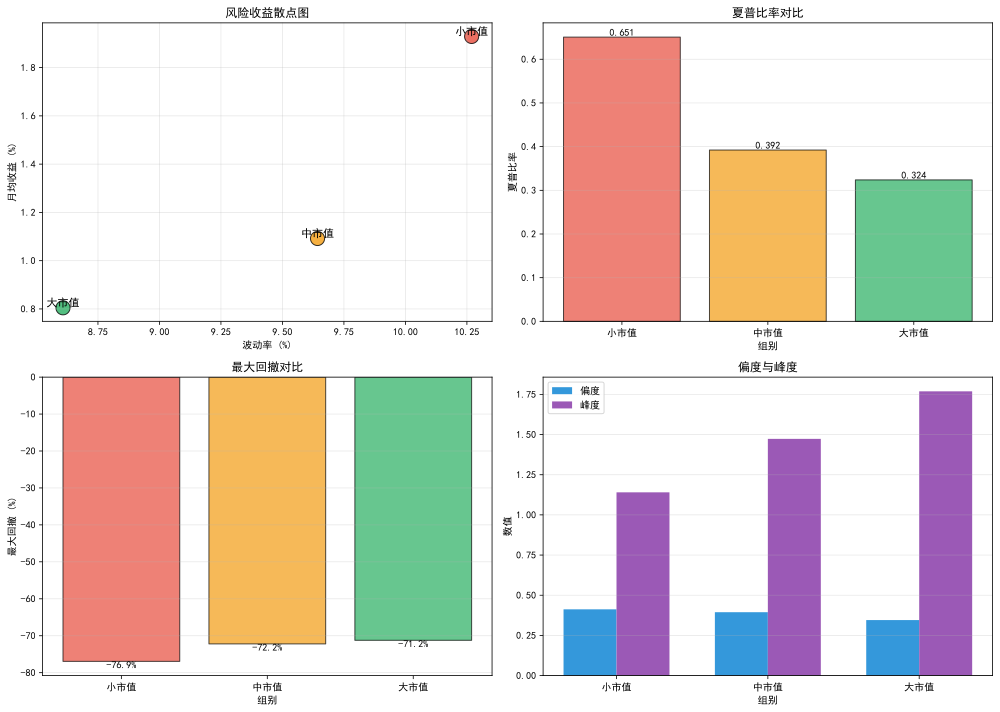

简要分析结果：
小市值:
  月均收益: 1.93%, 波动率: 10.27%
  夏普比率: 0.651, 最大回撤: -76.9%

中市值:
  月均收益: 1.09%, 波动率: 9.64%
  夏普比率: 0.392, 最大回撤: -72.2%

大市值:
  月均收益: 0.80%, 波动率: 8.61%
  夏普比率: 0.324, 最大回撤: -71.2%



In [54]:
import matplotlib.pyplot as plt
import numpy as np

# 可视化风险收益特征 - 简化版本
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 设置颜色
colors = ['#e74c3c', '#f39c12', '#27ae60']

# 1. 风险收益散点图
ax1 = axes[0, 0]
for i, row in risk_df.iterrows():
    ax1.scatter(row['波动率(%)'], row['月均收益(%)'], 
                s=200, color=colors[i%3], alpha=0.8, edgecolor='black')
    ax1.text(row['波动率(%)'], row['月均收益(%)'], row['组别'], 
             fontsize=11, ha='center', va='bottom')

ax1.set_xlabel('波动率 (%)')
ax1.set_ylabel('月均收益 (%)')
ax1.set_title('风险收益散点图')
ax1.grid(True, alpha=0.3)

# 2. 夏普比率条形图
ax2 = axes[0, 1]
bars = ax2.bar(range(len(risk_df)), risk_df['夏普比率'], 
               color=colors, alpha=0.7, edgecolor='black')
ax2.set_xlabel('组别')
ax2.set_ylabel('夏普比率')
ax2.set_title('夏普比率对比')
ax2.set_xticks(range(len(risk_df)))
ax2.set_xticklabels(risk_df['组别'])
ax2.grid(axis='y', alpha=0.3)

# 添加数值
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom')

# 3. 最大回撤条形图
ax3 = axes[1, 0]
bars2 = ax3.bar(range(len(risk_df)), risk_df['最大回撤(%)'], 
                color=colors, alpha=0.7, edgecolor='black')
ax3.set_xlabel('组别')
ax3.set_ylabel('最大回撤 (%)')
ax3.set_title('最大回撤对比')
ax3.set_xticks(range(len(risk_df)))
ax3.set_xticklabels(risk_df['组别'])
ax3.grid(axis='y', alpha=0.3)

# 添加数值
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='top' if height < 0 else 'bottom')

# 4. 偏度峰度对比图
ax4 = axes[1, 1]
x = np.arange(len(risk_df))
width = 0.35

bars3 = ax4.bar(x - width/2, risk_df['偏度'], width, label='偏度', color='#3498db')
bars4 = ax4.bar(x + width/2, risk_df['峰度'], width, label='峰度', color='#9b59b6')

ax4.set_xlabel('组别')
ax4.set_ylabel('数值')
ax4.set_title('偏度与峰度')
ax4.set_xticks(x)
ax4.set_xticklabels(risk_df['组别'])
ax4.legend()
ax4.grid(axis='y', alpha=0.3)
ax4.axhline(y=0, color='black', linewidth=0.5)

plt.tight_layout()
plt.show()

# 打印简要分析
print("简要分析结果：")
for _, row in risk_df.iterrows():
    print(f"{row['组别']}:")
    print(f"  月均收益: {row['月均收益(%)']:.2f}%, 波动率: {row['波动率(%)']:.2f}%")
    print(f"  夏普比率: {row['夏普比率']:.3f}, 最大回撤: {row['最大回撤(%)']:.1f}%")
    print()